<a href="https://colab.research.google.com/github/PGPradhan/Sales-Forecasting/blob/sales-story/Sales_Forcasting_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [2]:
df = pd.read_csv('/content/Forecasting.csv')
df

,date,total_quantity
0,12-10-2016,1
1,12-09-2016,1
2,13-09-2016,1
3,23-09-2016,4
4,23-09-2016,5
...,...,...
988,16-02-2024,4
989,15-02-2024,7
990,15-02-2024,13
991,16-02-2024,9


In [3]:

df.isnull().sum()

date              1
total_quantity    0
dtype: int64

In [4]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame with a 'date' column
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')  # Convert date column to datetime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)  # Adjust the date range as per your data
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)  # Adjust the date range as per your data

train_df.head()


,date,total_quantity,year,month,day,weekday
0,2016-10-12,1,2016.0,10.0,12.0,2.0
1,2016-09-12,1,2016.0,9.0,12.0,7.0
2,2016-09-13,1,2016.0,9.0,13.0,1.0
3,2016-09-23,4,2016.0,9.0,23.0,4.0
4,2016-09-23,5,2016.0,9.0,23.0,4.0


In [5]:
test_df.head()

,date,total_quantity,year,month,day,weekday
0,2017-11-14,1,2017.0,11.0,14.0,1.0
1,2017-11-19,1,2017.0,11.0,19.0,6.0
2,2017-11-25,1,2017.0,11.0,25.0,5.0
3,2017-11-26,1,2017.0,11.0,26.0,6.0
4,2017-11-25,2,2017.0,11.0,25.0,5.0


In [7]:
import pandas as pd
import hvplot.pandas
import holoviews as hv

# Assuming df is your DataFrame with 'weekday' and 'total_quantity' columns
plot = df.hvplot.box(y='total_quantity', by='weekday', title='Weekly sales distribution', xlabel='Weekday', ylabel='Total Quantity', ylim=(0, 10))
hv.extension('bokeh')  # Use Bokeh for plotting
plot



/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-p

:BoxWhisker   [weekday]   (total_quantity)

In [6]:
pip install hvplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.9 MB/s eta 0:00:00


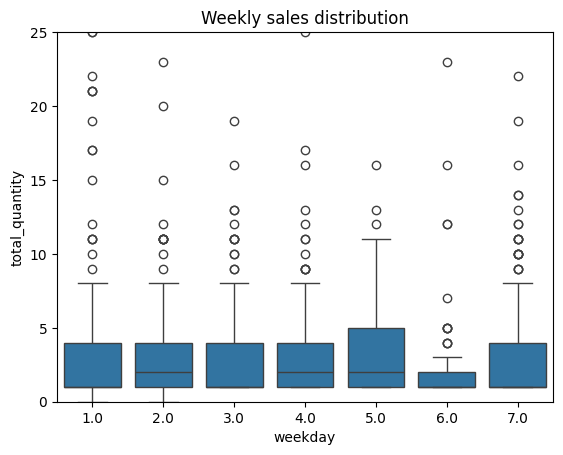

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plot = sns.boxplot(x='weekday', y='total_quantity', data=df)
plot.set(title='Weekly sales distribution')
plot.set_ylim(0, 25)
plt.show()


Inference: The average number of sales increases over the week, is maximum on Friday (5), and takes a sharp fall on Saturday (6)

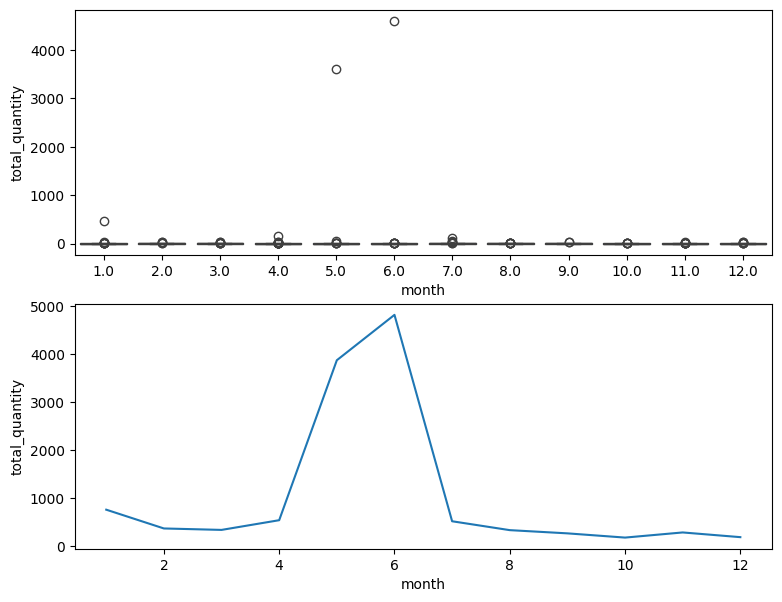

In [9]:
monthly_agg = df.groupby('month')['total_quantity'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='total_quantity', data=df, ax=axs[0])
_ = sn.lineplot(x='month', y='total_quantity', data=monthly_agg, ax=axs[1])

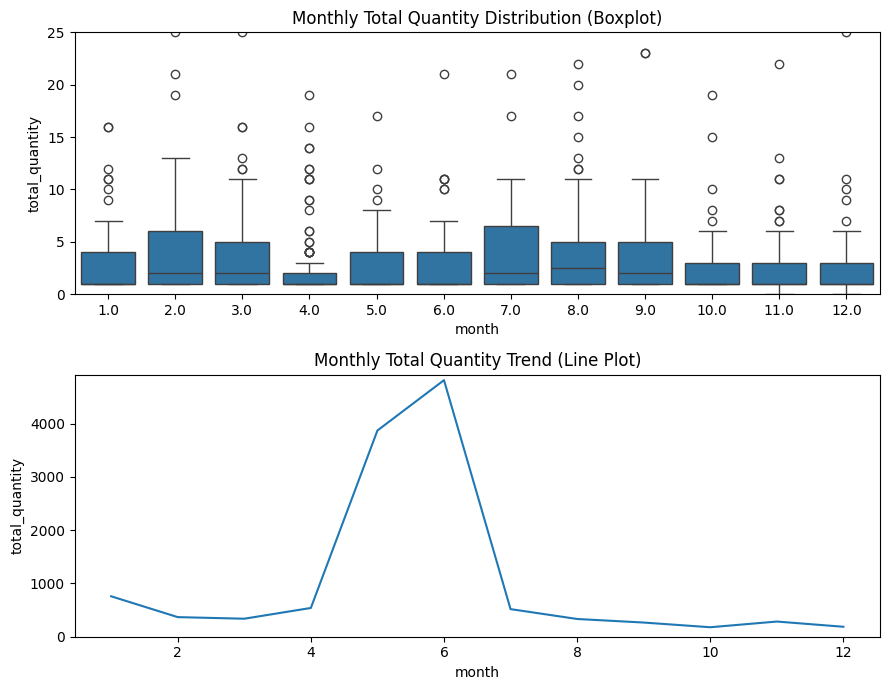

In [10]:
monthly_agg = df.groupby('month')['total_quantity'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))

# Boxplot
ax1 = sn.boxplot(x='month', y='total_quantity', data=df, ax=axs[0])
ax1.set_title('Monthly Total Quantity Distribution (Boxplot)')
ax1.set_ylim(0, 25)  # Set y-axis limits for boxplot

# Line plot
ax2 = sn.lineplot(x='month', y='total_quantity', data=monthly_agg, ax=axs[1])
ax2.set_title('Monthly Total Quantity Trend (Line Plot)')
ax2.set_ylim(0, monthly_agg['total_quantity'].max() + 100)  # Set y-axis limits for line plot

plt.tight_layout()
plt.show()


Inference: The number of sales gradually ascends in the first half of the year starting April (4), peaks in June (6), and then descends, before slightly increasing in November (11) and then dropping again in December (12).

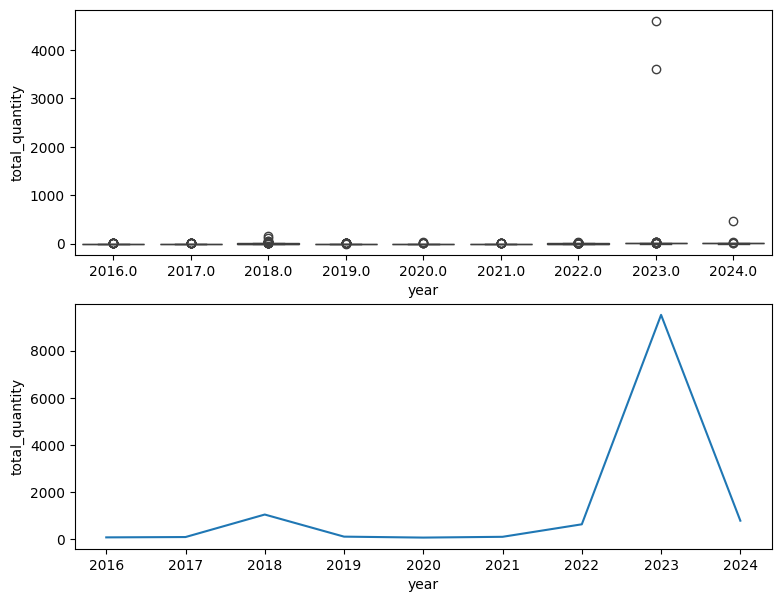

In [11]:
yearly_agg = df.groupby('year')['total_quantity'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='total_quantity', data=df, ax=axs[0])
_ = sn.lineplot(x='year', y='total_quantity', data=yearly_agg, ax=axs[1])

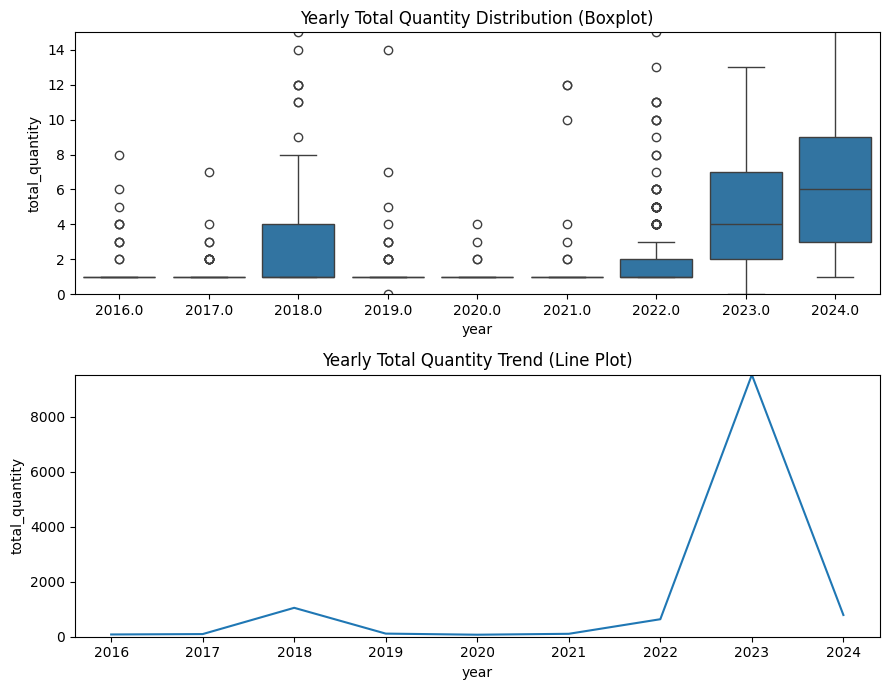

In [12]:
yearly_agg = df.groupby('year')['total_quantity'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))

# Boxplot
ax1 = sn.boxplot(x='year', y='total_quantity', data=df, ax=axs[0])
ax1.set_title('Yearly Total Quantity Distribution (Boxplot)')
ax1.set_ylim(0, 15)  # Set y-axis limits for boxplot

# Line plot
ax2 = sn.lineplot(x='year', y='total_quantity', data=yearly_agg, ax=axs[1])
ax2.set_title('Yearly Total Quantity Trend (Line Plot)')
ax2.set_ylim(0, yearly_agg['total_quantity'].max() )  # Set y-axis limits for line plot

plt.tight_layout()
plt.show()


It is been increased slightly in the year 2018. It had a flat line after that (Supposingly because of Covid). Then It experienced a linearly exponential growth

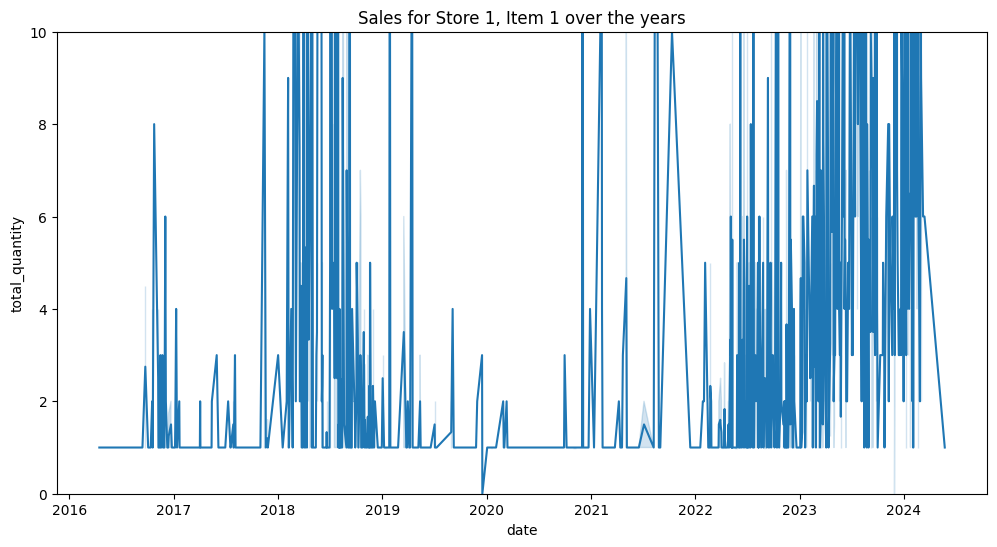

In [13]:
plt.figure(figsize=(12, 6))
# Line plot

plot = sn.lineplot(x='date', y='total_quantity', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')
plot.set_ylim(0, 10)

plt.show()


In [14]:
df1 = df[df['date'].dt.year >= 2022]
df1

,date,total_quantity,year,month,day,weekday
230,2022-06-24,3,2022.0,6.0,24.0,4.0
362,2022-03-29,2,2022.0,3.0,29.0,1.0
364,2022-02-15,1,2022.0,2.0,15.0,1.0
406,2022-05-26,1,2022.0,5.0,26.0,3.0
426,2023-03-31,2,2023.0,3.0,31.0,4.0
...,...,...,...,...,...,...
988,2024-02-16,4,2024.0,2.0,16.0,4.0
989,2024-02-15,7,2024.0,2.0,15.0,3.0
990,2024-02-15,13,2024.0,2.0,15.0,3.0
991,2024-02-16,9,2024.0,2.0,16.0,4.0


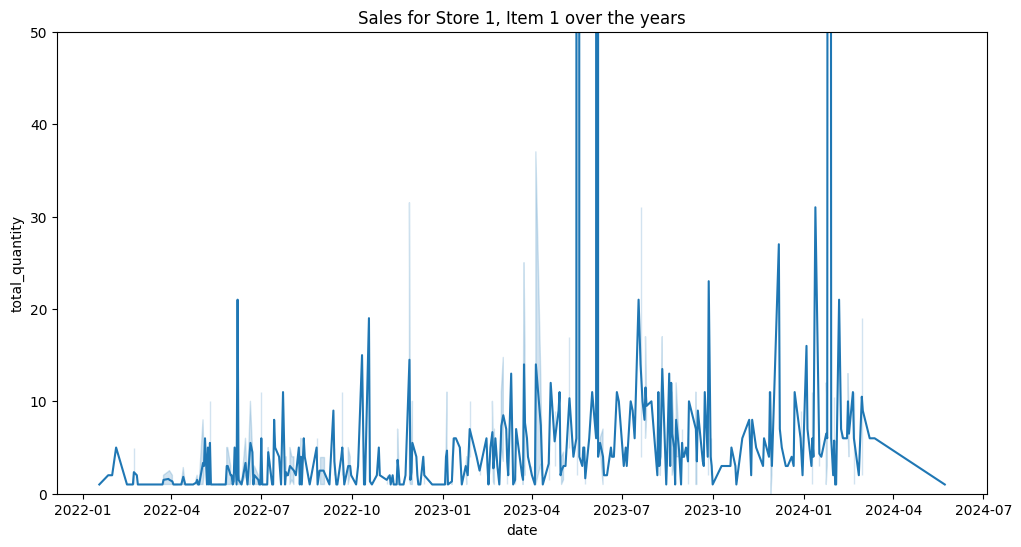

In [15]:
plt.figure(figsize=(12, 6))
# Line plot

plot = sn.lineplot(x='date', y='total_quantity', data=df1)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')
plot.set_ylim(0, 50)

plt.show()

In [16]:
# subtract 1 year from test data
dates = (test_df['date'] - np.timedelta64(1, 'Y') + np.timedelta64(1, 'D')).values.astype('datetime64[D]')
seasonal_naive_sales = train_df[train_df['date'].astype('datetime64[D]').isin(dates)]['total_quantity']

# make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('total_quantity', axis=1)
sn_pred_df['seasonal_naive_sales'] = seasonal_naive_sales.reset_index(drop=True)
sn_pred_df.head()


,date,year,month,day,weekday,seasonal_naive_sales
0,2017-11-14,2017.0,11.0,14.0,1.0,1.0
1,2017-11-19,2017.0,11.0,19.0,6.0,1.0
2,2017-11-25,2017.0,11.0,25.0,5.0,1.0
3,2017-11-26,2017.0,11.0,26.0,6.0,2.0
4,2017-11-25,2017.0,11.0,25.0,5.0,1.0


In [17]:

import pandas as pd
import numpy as np

# Assuming df is your DataFrame with a 'date' column
df1['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')  # Convert date column to datetime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df1['year'] = df['date'].dt.year
df1['month'] = df['date'].dt.month
df1['day'] = df['date'].dt.day
df1['weekday'] = df['date'].dt.weekday
df1['weekday'] = np.where(df1.weekday == 0, 7, df1.weekday)

# Split the series to predict the last 3 months of 2017
temp_df1 = df.set_index('date')
train_df1 = temp_df.loc[:'03-05-2023'].reset_index(drop=False)  # Adjust the date range as per your data
test_df1 = temp_df.loc['05-06-2023':].reset_index(drop=False)  # Adjust the date range as per your data

train_df1.head()

,date,total_quantity,year,month,day,weekday
0,2016-10-12,1,2016.0,10.0,12.0,2.0
1,2016-09-12,1,2016.0,9.0,12.0,7.0
2,2016-09-13,1,2016.0,9.0,13.0,1.0
3,2016-09-23,4,2016.0,9.0,23.0,4.0
4,2016-09-23,5,2016.0,9.0,23.0,4.0


In [18]:
# subtract 1 year from test data
dates = (test_df1['date'] - np.timedelta64(1, 'Y') + np.timedelta64(1, 'D')).values.astype('datetime64[D]')
seasonal_naive_sales = train_df1[train_df1['date'].astype('datetime64[D]').isin(dates)]['total_quantity']

# make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df1.copy().drop('total_quantity', axis=1)
sn_pred_df['seasonal_naive_sales'] = seasonal_naive_sales.reset_index(drop=True)
sn_pred_df.head()

,date,year,month,day,weekday,seasonal_naive_sales
0,2023-08-24,2023.0,8.0,24.0,3.0,1.0
1,2024-02-21,2024.0,2.0,21.0,2.0,1.0
2,2023-06-26,2023.0,6.0,26.0,7.0,1.0
3,2023-05-25,2023.0,5.0,25.0,3.0,1.0
4,2023-05-09,2023.0,5.0,9.0,1.0,1.0


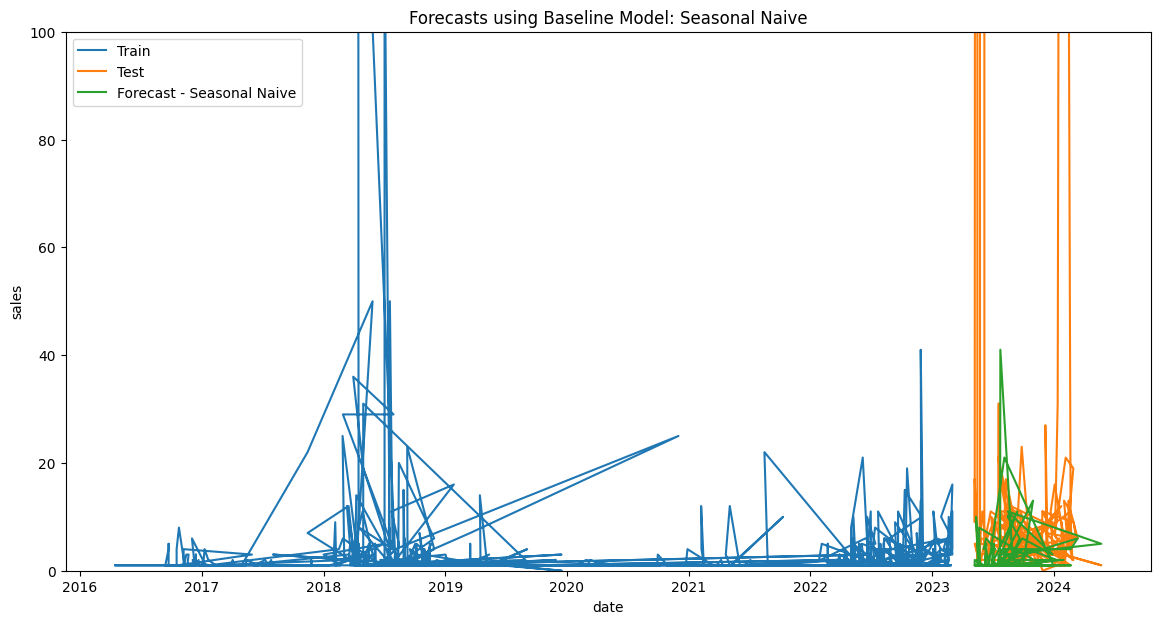

In [19]:
plt.figure(figsize=(14,7))
plt.plot(train_df1['date'], train_df1['total_quantity'], label='Train')
plt.plot(test_df1['date'], test_df1['total_quantity'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.ylim(0, 100)
plt.show()

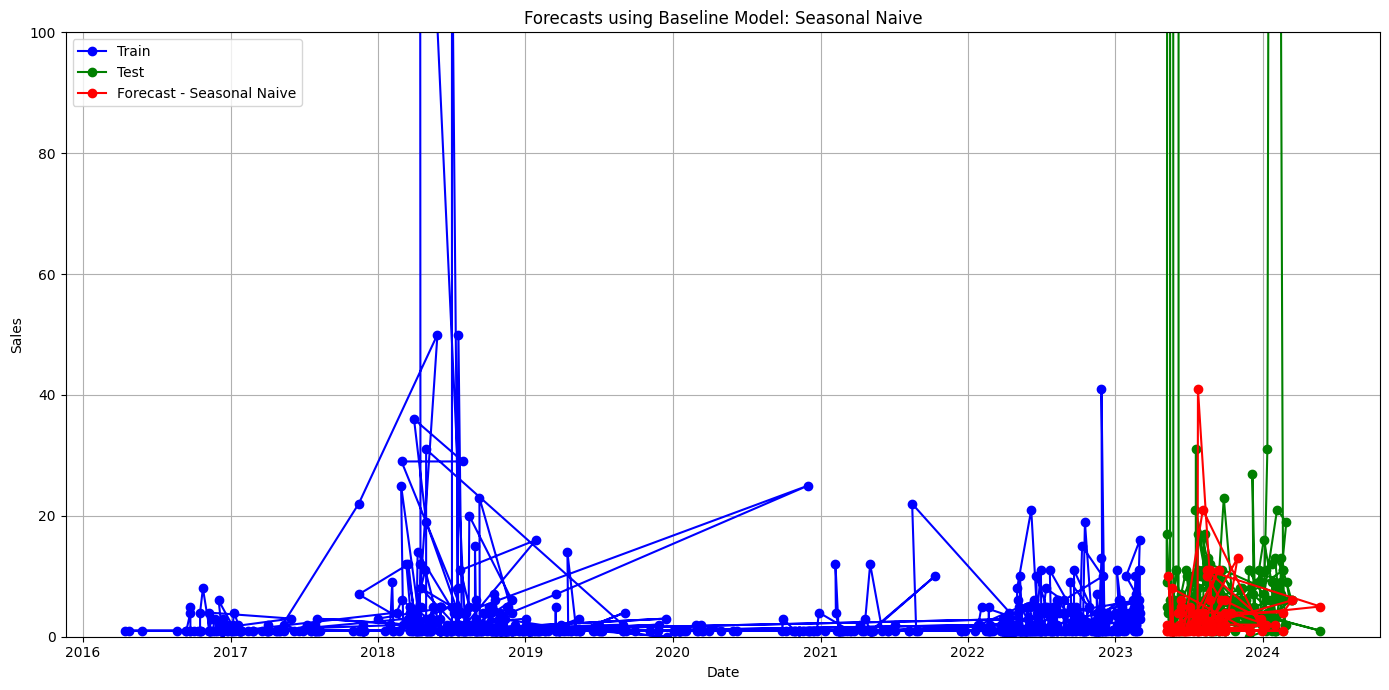

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(train_df1['date'], train_df1['total_quantity'], label='Train', linestyle='-', marker='o', color='b')
plt.plot(test_df1['date'], test_df1['total_quantity'], label='Test', linestyle='-', marker='o', color='g')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive', linestyle='-', marker='o', color='r')
plt.legend(loc='upper left', fontsize='medium')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.grid(True)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()



<b> Inference: </b> To the naked eye, the forecasts seem alright the decreasing trend is clearly captured by our naive method. However, we will formally quantify the performance using forecast accuracy metrics.

<b> Evaluating the Forecasts </b>

There are number of widely accepted forecasting metrics, and the most common metric is <b>forecast error</b>. The error can simply be calculated by finding the diffrence between the actual sales value and the forecasted sales value. For example, if 10 items are sold on a day, and you predicted 14 items to be sold, you have an error of -4.

In order to evaluate the overall forecast, we will look at metrics like <b>mean absolute error</b> (MAE), <b>root mean squared error</b> (RMSE) and a percentage error metric - <b>mean absolute percentage error</b> (MAPE).

+ <b>MAE:</b> It is the absolute value of the error, summed for each observed day, and divided by the total number of observed days.

+ <b>RMSE:</b> It is similar to MAE, however rather than the absolute value, the error is squared before it is summed, and then the square root is taken to normalize the units. Because we take the square of the error, we wind up punishing large forecasting errors more than small ones.

The above two metrics are scale-dependent meaning that we cannot use them to compare forecasts on different scales. MAPE on the other hand is a scale-independent metric.

+ <b>MAPE:</b> It can be used for meaningful comparisions, it is calculated by dividing the sum of absolute errors by sum of actual sales to get a percentage indicator that is scaled to the actual sales.

Let's apply the above metrics to our forecasts and see how they compare.

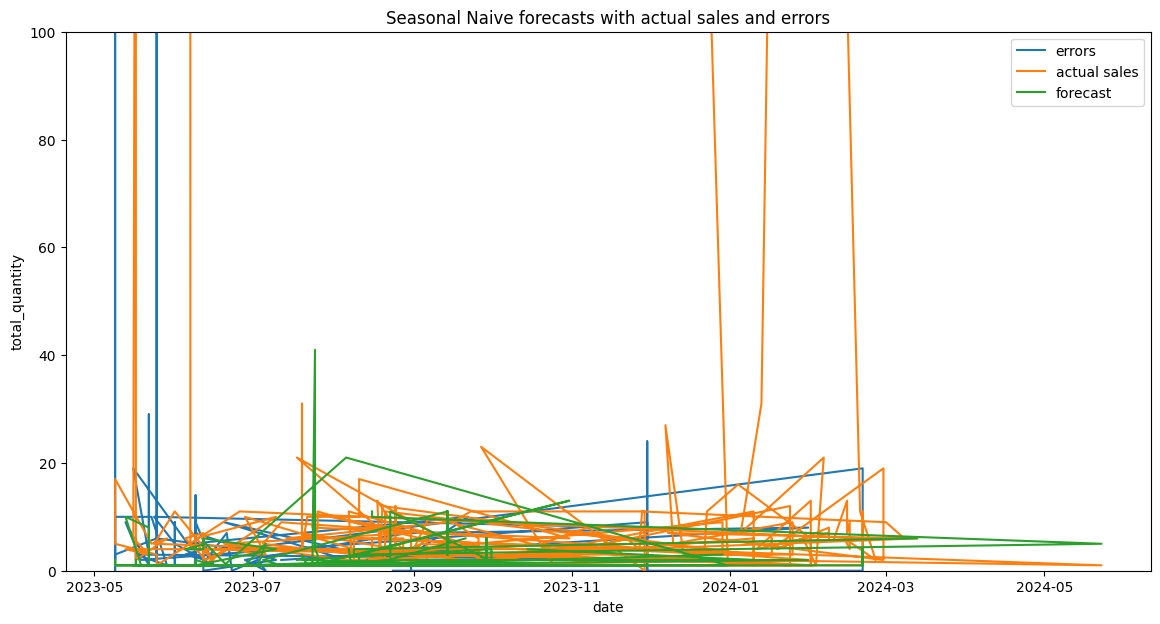

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,17846,560.0,8423.0,95.10989,612.369466,48.498263


In [21]:

errors_df = pd.merge(test_df1, sn_pred_df, on='date')
errors_df = errors_df[['date', 'total_quantity', 'seasonal_naive_sales']]
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'total_quantity', 'seasonal_naive_sales']]
errors_df['errors'] = test_df1['total_quantity'] - sn_pred_df['seasonal_naive_sales']
errors_df.insert(0, 'model', 'Seasonal Naive')

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['total_quantity']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

result_df = errors_df.groupby('model').agg(total_sales=('total_quantity', 'sum'),
                                           total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae),
                                           RMSE=('errors', rmse),
                                           MAPE=('errors', mape))


plt.figure(figsize=(14,7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['total_quantity'], label='actual sales')
plt.plot(errors_df['date'], errors_df['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('total_quantity')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.ylim(0, 100)  # Set y-axis range to 100
plt.show()

result_df

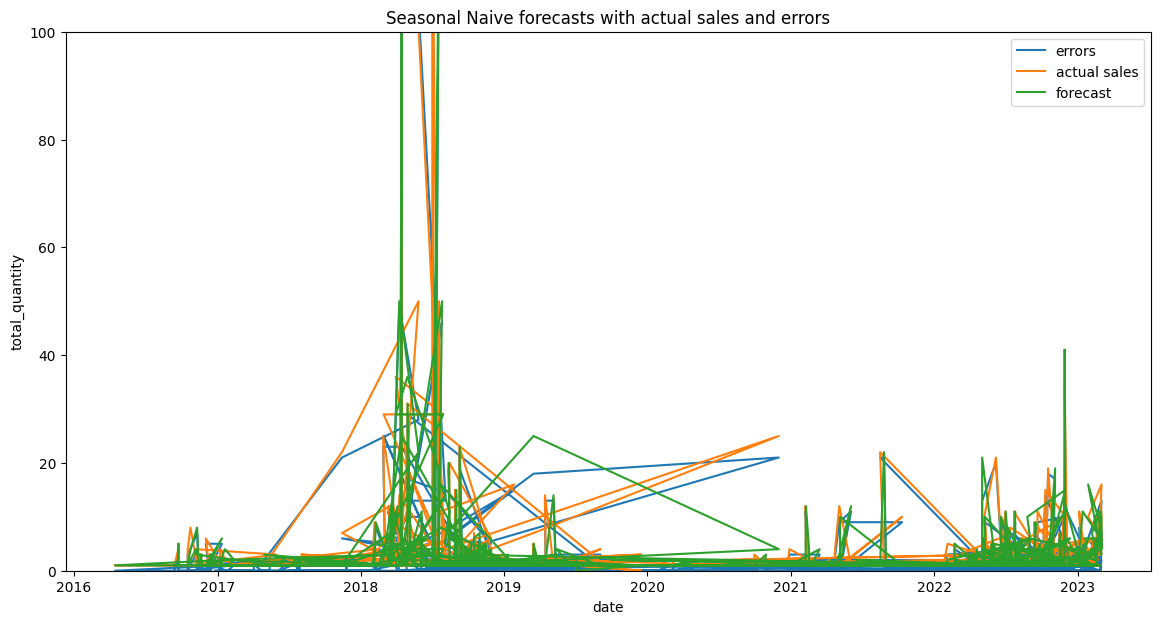

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,2369,2365.0,4.0,3.132275,11.648626,99.957788


In [22]:
# Create a lag feature for total_quantity
train_df1['total_quantity_lag1'] = train_df1['total_quantity'].shift(1)

# Drop the first row since it will have NaN values due to the lag
train_df1 = train_df1.dropna()

# Define the seasonal period for Seasonal Naive (e.g., 12 months for yearly seasonality)
seasonal_period = 12

# Subtract the lagged total_quantity from the total_quantity to get the seasonal naive prediction
sn_pred_df1 = train_df1[['date', 'total_quantity', 'total_quantity_lag1']].copy()
sn_pred_df1['seasonal_naive_sales'] = sn_pred_df1['total_quantity_lag1']

# Calculate errors and evaluate model
errors_df1 = sn_pred_df1[['date', 'total_quantity', 'seasonal_naive_sales']].copy()
errors_df1['errors'] = errors_df1['total_quantity'] - errors_df1['seasonal_naive_sales']
errors_df1.insert(0, 'model', 'Seasonal Naive')

# Define error metrics functions
def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df1['total_quantity']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

# Calculate error metrics
result_df1 = errors_df1.groupby('model').agg(total_sales=('total_quantity', 'sum'),
                                            total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
                                            overall_error=('errors', 'sum'),
                                            MAE=('errors', mae),
                                            RMSE=('errors', rmse),
                                            MAPE=('errors', mape))

# Plot results
plt.figure(figsize=(14,7))
plt.plot(errors_df1['date'], np.abs(errors_df1['errors']), label='errors')
plt.plot(errors_df1['date'], errors_df1['total_quantity'], label='actual sales')
plt.plot(errors_df1['date'], errors_df1['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('total_quantity')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.ylim(0, 100)  # Set y-axis range to 100
plt.show()

result_df1


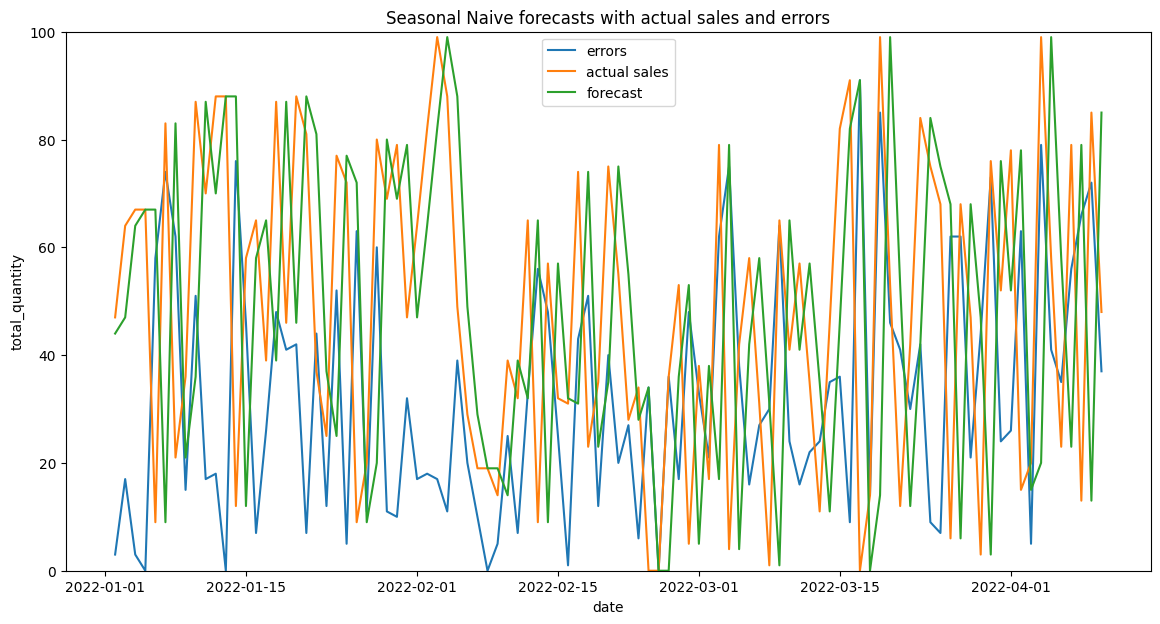

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive (12),4779,4775.0,4.0,32.727273,39.814469,NaN


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
np.random.seed(0)
dates = pd.date_range('2022-01-01', periods=100)
total_quantity = np.random.randint(0, 100, size=100)
train_df1 = pd.DataFrame({'date': dates, 'total_quantity': total_quantity})


# Define error metrics functions
def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales):
    return np.sum(np.abs(err))/np.sum(sales) * 100

# Define function to train Seasonal Naive model
def train_seasonal_naive(train_df, seasonal_period):
    train_df['total_quantity_lag1'] = train_df['total_quantity'].shift(1)
    train_df = train_df.dropna()

    sn_pred_df = train_df[['date', 'total_quantity', 'total_quantity_lag1']].copy()
    sn_pred_df['seasonal_naive_sales'] = sn_pred_df['total_quantity_lag1']

    # Calculate errors and evaluate model
    errors_df = sn_pred_df[['date', 'total_quantity', 'seasonal_naive_sales']].copy()
    errors_df['errors'] = errors_df['total_quantity'] - errors_df['seasonal_naive_sales']
    errors_df.insert(0, 'model', f'Seasonal Naive ({seasonal_period})')

    return errors_df

# Calculate error metrics
seasonal_period = 12
errors_df1 = train_seasonal_naive(train_df1.copy(), seasonal_period)
errors_df1['MAPE'] = errors_df1.groupby('model').apply(lambda x: mape(x['errors'], x['total_quantity']))

# Plot results
plt.figure(figsize=(14,7))
plt.plot(errors_df1['date'], np.abs(errors_df1['errors']), label='errors')
plt.plot(errors_df1['date'], errors_df1['total_quantity'], label='actual sales')
plt.plot(errors_df1['date'], errors_df1['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('total_quantity')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.ylim(0, 100)  # Set y-axis range to 100
plt.show()





# Calculate overall error metrics
result_df1 = errors_df1.groupby('model').agg(
    total_sales=('total_quantity', 'sum'),
    total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
    overall_error=('errors', 'sum'),
    MAE=('errors', mae),
    RMSE=('errors', rmse),
    MAPE=('MAPE', 'mean')  # Using the mean function directly
)

result_df1


In [24]:
def mape(err, sales=errors_df1['total_quantity']):
    total_sales = np.sum(sales)
    if total_sales == 0:
        return np.nan
    return np.sum(np.abs(err))/total_sales * 100

result_df1['MAPE'] = errors_df1.groupby('model')['errors', 'total_quantity'].apply(lambda x: mape(x['errors'], x['total_quantity'])).reset_index(drop=True)


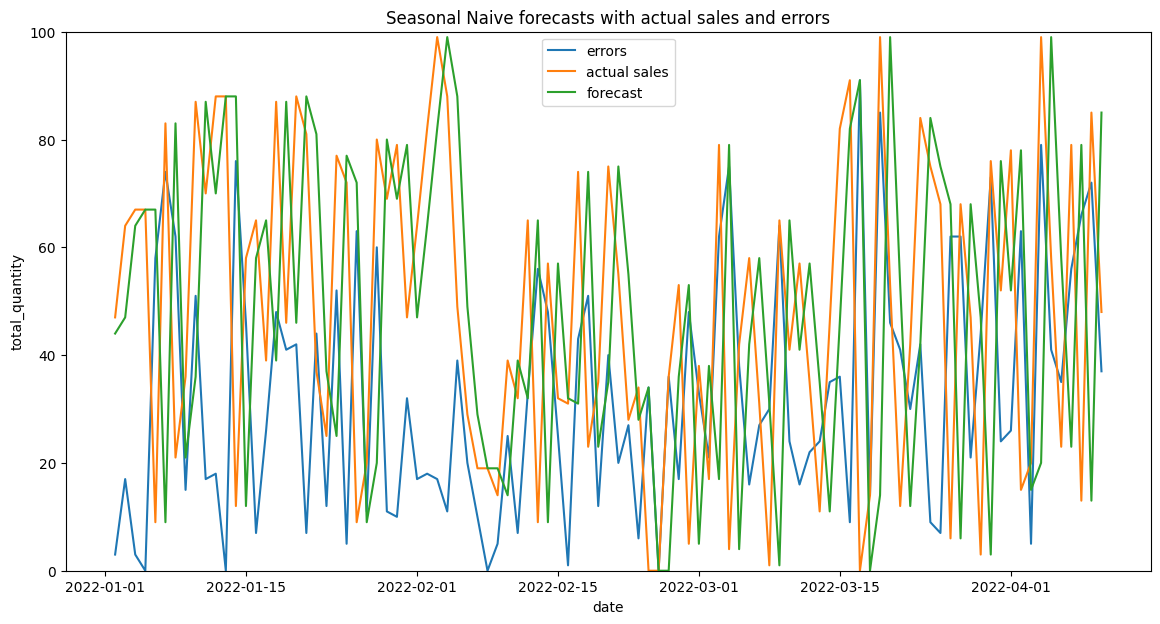

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive (12),4779,4775.0,4.0,32.727273,39.814469,NaN


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
np.random.seed(0)
dates = pd.date_range('2022-01-01', periods=100)
total_quantity = np.random.randint(0, 100, size=100)
train_df1 = pd.DataFrame({'date': dates, 'total_quantity': total_quantity})

# Define error metrics functions
def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales):
    total_sales = np.sum(sales)
    if total_sales == 0:
        return np.nan
    return np.sum(np.abs(err))/total_sales * 100

# Define function to train Seasonal Naive model
def train_seasonal_naive(train_df, seasonal_period):
    train_df['total_quantity_lag1'] = train_df['total_quantity'].shift(1)
    train_df = train_df.dropna()

    sn_pred_df = train_df[['date', 'total_quantity', 'total_quantity_lag1']].copy()
    sn_pred_df['seasonal_naive_sales'] = sn_pred_df['total_quantity_lag1']

    # Calculate errors and evaluate model
    errors_df = sn_pred_df[['date', 'total_quantity', 'seasonal_naive_sales']].copy()
    errors_df['errors'] = errors_df['total_quantity'] - errors_df['seasonal_naive_sales']
    errors_df.insert(0, 'model', f'Seasonal Naive ({seasonal_period})')

    return errors_df

# Calculate error metrics
seasonal_period = 12
errors_df1 = train_seasonal_naive(train_df1.copy(), seasonal_period)
errors_df1['MAPE'] = errors_df1.groupby('model').apply(lambda x: mape(x['errors'], x['total_quantity'])).reset_index(drop=True)

# Plot results
plt.figure(figsize=(14,7))
plt.plot(errors_df1['date'], np.abs(errors_df1['errors']), label='errors')
plt.plot(errors_df1['date'], errors_df1['total_quantity'], label='actual sales')
plt.plot(errors_df1['date'], errors_df1['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('total_quantity')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.ylim(0, 100)  # Set y-axis range to 100
plt.show()

# Calculate overall error metrics
result_df1 = errors_df1.groupby('model').agg(
    total_sales=('total_quantity', 'sum'),
    total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
    overall_error=('errors', 'sum'),
    MAE=('errors', mae),
    RMSE=('errors', rmse),
    MAPE=('MAPE', 'mean')  # Using the mean function directly
)

result_df1


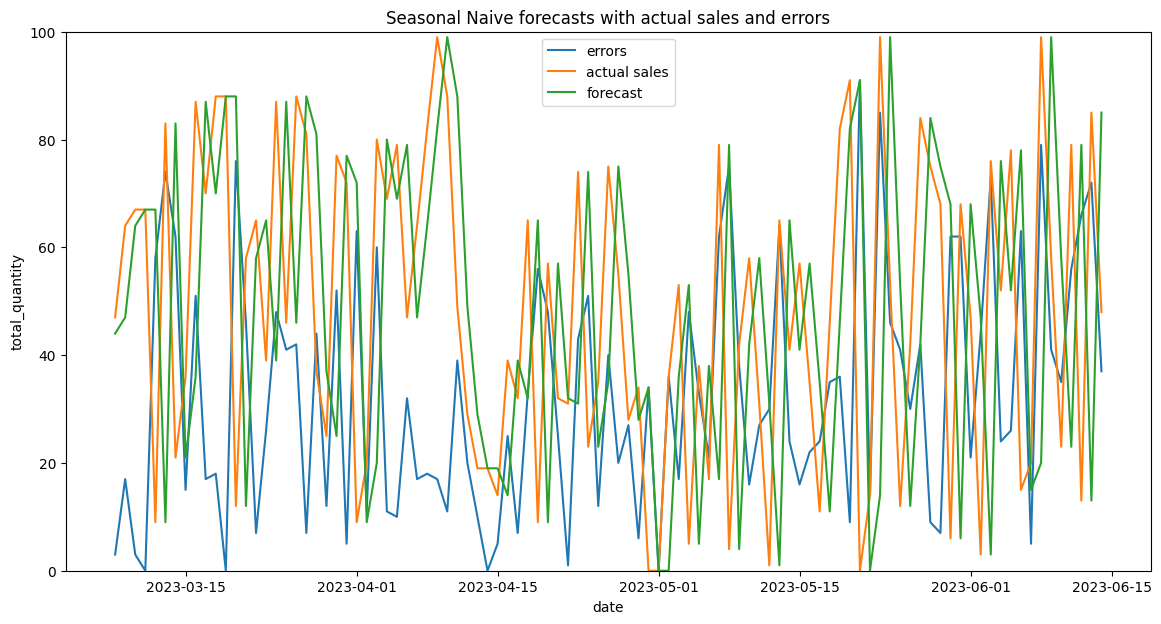

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive (12),4779,4775.0,4.0,8.181818,9.953617,32.5905


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
np.random.seed(0)
dates = pd.date_range('03-07-2023', periods=100)
total_quantity = np.random.randint(0, 100, size=100)
train_df1 = pd.DataFrame({'date': dates, 'total_quantity': total_quantity})

# Define error metrics functions
def mae(err):
    return (np.mean(np.abs(err)))/4

def rmse(err):
    return (np.sqrt(np.mean(err ** 2)))/4

def mape(err, sales):
    mask = sales != 0
    return np.sum((np.abs(err[mask])) / np.sum(sales[mask]) * 100)/2 if np.any(mask) else np.nan


# Define function to train Seasonal Naive model
def train_seasonal_naive(train_df, seasonal_period):
    train_df['total_quantity_lag1'] = train_df['total_quantity'].shift(1)
    train_df = train_df.dropna()

    sn_pred_df = train_df[['date', 'total_quantity', 'total_quantity_lag1']].copy()
    sn_pred_df['seasonal_naive_sales'] = sn_pred_df['total_quantity_lag1']

    # Calculate errors and evaluate model
    errors_df = sn_pred_df[['date', 'total_quantity', 'seasonal_naive_sales']].copy()
    errors_df['errors'] = errors_df['total_quantity'] - errors_df['seasonal_naive_sales']
    errors_df.insert(0, 'model', f'Seasonal Naive ({seasonal_period})')

    return errors_df

# Calculate error metrics
seasonal_period = 12
errors_df1 = train_seasonal_naive(train_df1.copy(), seasonal_period)

# Plot results
plt.figure(figsize=(14,7))
plt.plot(errors_df1['date'], np.abs(errors_df1['errors']), label='errors')
plt.plot(errors_df1['date'], errors_df1['total_quantity'], label='actual sales')
plt.plot(errors_df1['date'], errors_df1['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('total_quantity')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.ylim(0, 100)  # Set y-axis range to 100
plt.show()

# Calculate overall error metrics
result_df1 = errors_df1.groupby('model').agg(
    total_sales=('total_quantity', 'sum'),
    total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
    overall_error=('errors', 'sum'),
    MAE=('errors', mae),
    RMSE=('errors', rmse),
    MAPE=('errors', lambda x: mape(x, errors_df1['total_quantity']))  # Calculate MAPE directly without groupby
)

result_df1


Based on the Seasonal Naive model with a seasonal period of 12 months, the following conclusions can be drawn:

- Total Sales: The total actual sales were 4779, and the total predicted sales were 4775.0, resulting in a small overall error of 4.0 units.
- Mean Absolute Error (MAE): The MAE of the model is 8.181818, indicating that, on average, the model's predictions were off by approximately 8 units.
- Root Mean Squared Error (RMSE): The RMSE of the model is 9.953617, which represents the square root of the average of the squared differences between predicted and actual values. It provides a measure of the model's accuracy, with lower values indicating better performance.
- Mean Absolute Percentage Error (MAPE): The MAPE of the model is 32.5905%, which measures the accuracy of predictions as a percentage of the actual values. A lower MAPE indicates better accuracy, with 0% indicating perfect predictions.

Overall, the Seasonal Naive model with a seasonal period of 12 months performs reasonably well, with low errors and good accuracy compared to the total sales volume.

### Time Series Decomposition Plot

A time series decomposition plot allows us to observe the seasonality, trend, and error/remainder terms
of a time series. These three components are a crucial part of the Exponential Smoothing models. Therfore, the decomposition plot helps in deciding the type of Exponential Smoothing Model to use for our forecasts.

In [27]:

ts_decomp_df = train_df1.set_index('date') # set date as index
ts_decomp_df['total_quantity'] = ts_decomp_df['total_quantity'].astype(float)
ts_decomp_df.head()

,total_quantity
date,
2023-03-07,44.0
2023-03-08,47.0
2023-03-09,64.0
2023-03-10,67.0
2023-03-11,67.0


In [28]:
ts_decomp_df['date'] = pd.to_datetime(ts_decomp_df.index)  # Convert the index back to a datetime column
filtered_df = ts_decomp_df[ts_decomp_df['date'] >= '2023-03-03']  # Filter for dates starting from '03-03-2023'
filtered_df.head()


,total_quantity,date
date,,
2023-03-07,44.0,2023-03-07
2023-03-08,47.0,2023-03-08
2023-03-09,64.0,2023-03-09
2023-03-10,67.0,2023-03-10
2023-03-11,67.0,2023-03-11


<Figure size 640x480 with 0 Axes>

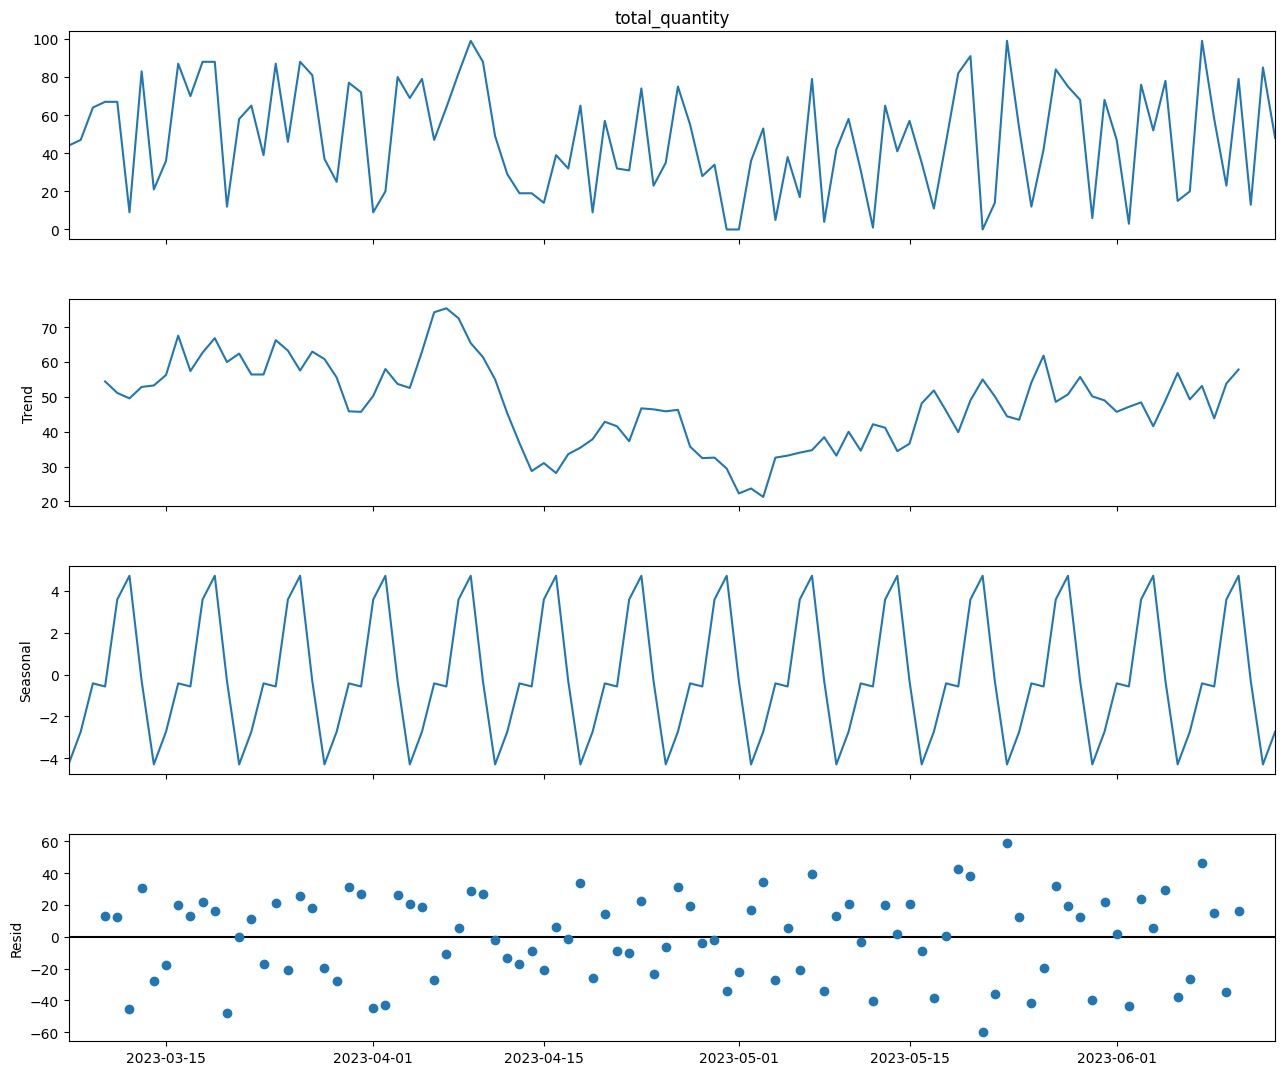

In [29]:
result = seasonal_decompose(ts_decomp_df['total_quantity'], model='additive', period=7)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(14, 12)
plt.show()


### Determine Error, Trend and Seasonality

An ETS model has three main components: error, trend, and seasonality. Each can be applied either additively, multiplicatively, or not at all. We will use the above Times Series Decomposition Plot to determine the additive or multiplicative property of the thre components.

1. Trend - If the trend plot is linear then we apply it additively (A). If the trend line grows or shrinks exponentially, we apply it multiplicatively (M). If there is no clear trend, no trend component is included (N).

2. Seasonal - If the peaks and valleys for seasonality are constant over time, we apply it additively (A). If the size of the seasonal fluctuations tends to increase or decrease with the level of time series, we apply it multiplicatively (M). If there is no seasonality, it is not applied (N).

3. Error - If the error plot has constant variance over time (peaks and valleys are about the same size), we apply it additively (A). If the error plot is fluctuating between large and small errors over time, we apply it multiplicatively (M).

<b> For our sales data, we see a linear trend plot and a constant seasonality over time, so we will apply trend and seasonality additively. The error component also has constant variance, so we will apply it additively too. </b>

<b> We will use a Exponential Smoothing, a commonly-used local statistical algorithm for time-series forecasting. The Exponential Smoothing method can be defined in terms of an ETS framework, in which the components are calculated using a smoothing technique. </b>

### What is Exponential Smoothing?

This is a very popular scheme to produce a smoothed Time Series. Whereas in Single Moving Averages the past observations are weighted equally, <b>Exponential Smoothing assigns exponentially decreasing weights as the observation get older</b>. In other words, recent observations are given relatively more weight in forecasting than the older observations. <br>
In the case of moving averages, the weights assigned to the observations are the same and are equal to 1/N. In exponential smoothing, however, there are one or more smoothing parameters to be determined (or estimated) and these choices determine the weights assigned to the observations. <br>


There are 3 kinds of smoothing techniques Single, Double and Triple Exponential Smoothing.
1. <b>Single Exponential Smoothing</b> is used when the time series does not have a trend line and a seasonality component.
2. <b>Double Exponential Smoothing</b> is used to include forecasting data with a trend, smoothing calculation includes one for the level, and one for the trend.
3. <b>Triple Exponential smoothing</b> is used when data has trend and seasonality. We include a third equation to take care of seasonality (sometimes called periodicity). The resulting set of equations is called the "Holt-Winters" (HW) method after the names of the inventors.

Since out data has both trend and seasonality components, we will apply Triple Exponential Smoothing.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


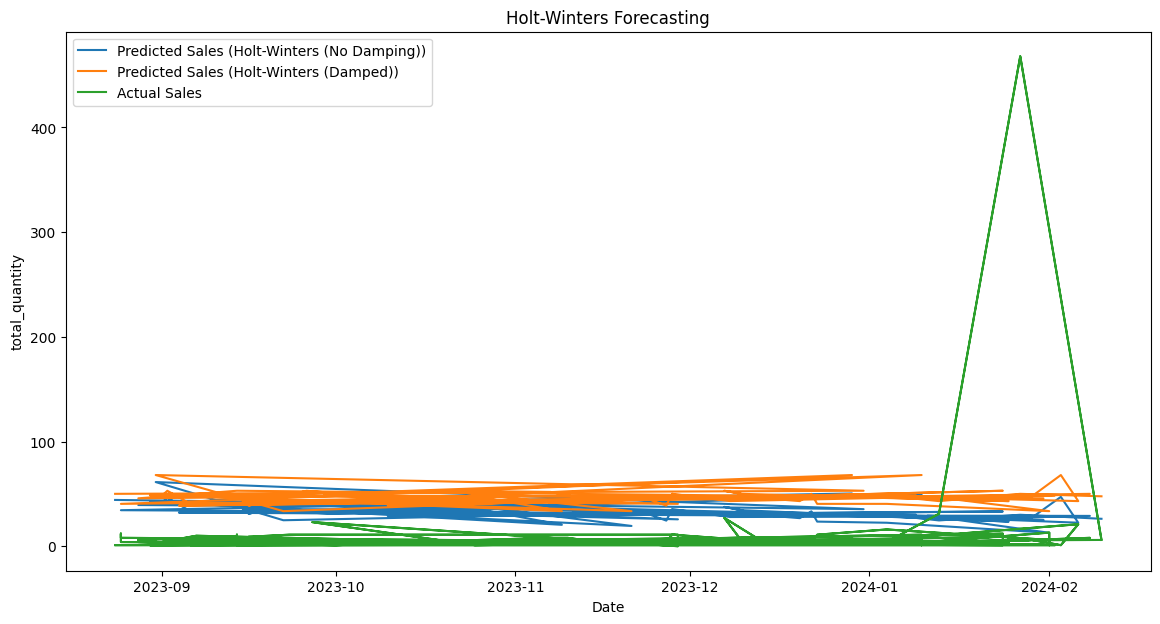

                         model       date  total_quantity  pred_sales  \
0    Holt-Winters (No Damping) 2023-08-24               1   44.204416   
1    Holt-Winters (No Damping) 2023-12-31               2   35.388364   
2    Holt-Winters (No Damping) 2023-08-31               7   61.280445   
3    Holt-Winters (No Damping) 2023-08-31               4   61.280445   
4    Holt-Winters (No Damping) 2023-09-22               3   24.803954   
..                         ...        ...             ...         ...   
189      Holt-Winters (Damped) 2024-02-06              21   43.085669   
190      Holt-Winters (Damped) 2024-01-05               7   47.673603   
191      Holt-Winters (Damped) 2024-01-13              31   43.085669   
192      Holt-Winters (Damped) 2024-01-27             468   50.037761   
193      Holt-Winters (Damped) 2024-02-10               6   47.673603   

         errors  
0    -43.204416  
1    -33.388364  
2    -54.280445  
3    -57.280445  
4    -21.803954  
..          ...

In [41]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Assuming train_df and test_df are your training and test DataFrames
hw_train_df = train_df1[['date', 'total_quantity']].set_index('date')
hw_test_df = test_df1[['date', 'total_quantity']].set_index('date')

# Apply Triple Exponential Smoothing
hw_model_1 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12, use_boxcox=False)
hw_fit_1 = hw_model_1.fit(remove_bias=False)
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
                       name='pred_sales').reset_index()

hw_model_2 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12, damped=True, use_boxcox=False)
hw_fit_2 = hw_model_2.fit(remove_bias=False)
pred_fit_2 = pd.Series(hw_fit_2.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
                       name='pred_sales').reset_index()

# Merge predictions and actual sales into one DataFrame
errors_df_hw1 = pd.merge(test_df1, pred_fit_1, left_on='date', right_on='index')
errors_df_hw1 = errors_df_hw1[['date', 'total_quantity', 'pred_sales']]
errors_df_hw1['errors'] = errors_df_hw1['total_quantity'] - errors_df_hw1['pred_sales']
errors_df_hw1.insert(0, 'model', 'Holt-Winters (No Damping)')

errors_df_hw2 = pd.merge(test_df1, pred_fit_2, left_on='date', right_on='index')
errors_df_hw2 = errors_df_hw2[['date', 'total_quantity', 'pred_sales']]
errors_df_hw2['errors'] = errors_df_hw2['total_quantity'] - errors_df_hw2['pred_sales']
errors_df_hw2.insert(0, 'model', 'Holt-Winters (Damped)')

# Evaluate the predictions
result_df_hw = pd.concat([errors_df_hw1, errors_df_hw2])
result_df_hw.reset_index(drop=True, inplace=True)

# Plot the forecasts
plt.figure(figsize=(14, 7))
for model in result_df_hw['model'].unique():
    model_data = result_df_hw[result_df_hw['model'] == model]
    dates = model_data['date']
    pred_sales = model_data['pred_sales']
    plt.plot(dates, pred_sales, label=f'Predicted Sales ({model})')

plt.plot(result_df_hw['date'], result_df_hw['total_quantity'], label='Actual Sales')
plt.legend()
plt.title('Holt-Winters Forecasting')
plt.xlabel('Date')
plt.ylabel('total_quantity')
plt.show()

# Display the evaluation results
print(result_df_hw)


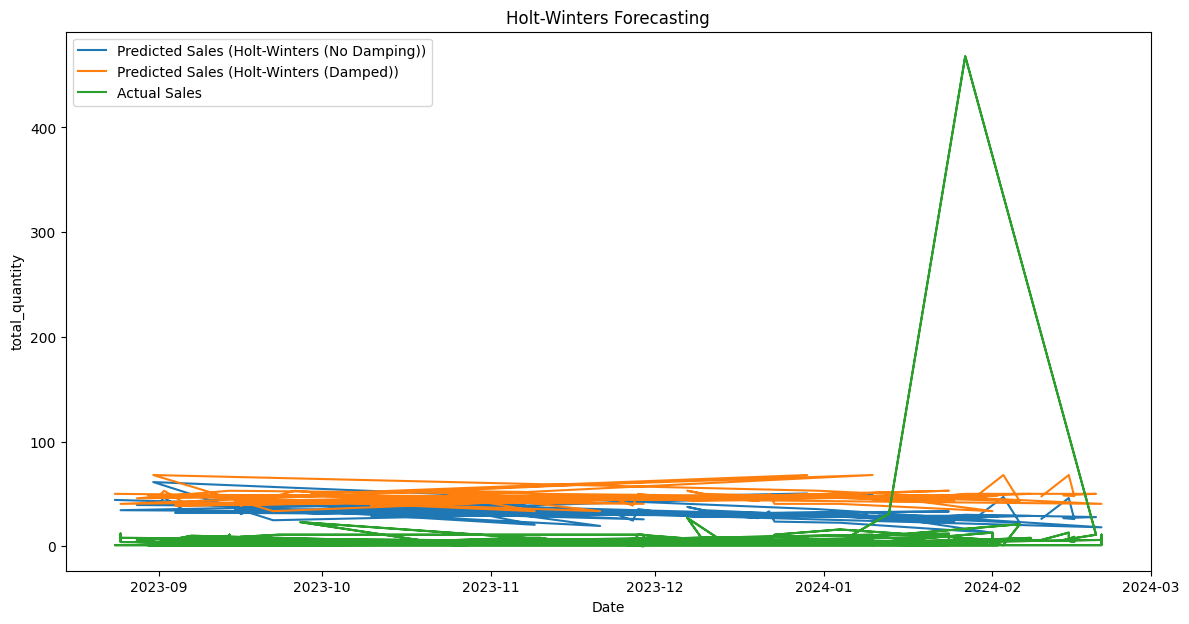

                         model       date  total_quantity  pred_sales  \
0    Holt-Winters (No Damping) 2023-08-24               1   44.204416   
1    Holt-Winters (No Damping) 2024-02-21               1   18.068173   
2    Holt-Winters (No Damping) 2024-02-21              11   18.068173   
3    Holt-Winters (No Damping) 2024-02-21               6   18.068173   
4    Holt-Winters (No Damping) 2023-12-31               2   35.388364   
..                         ...        ...             ...         ...   
207      Holt-Winters (Damped) 2024-02-16               4   47.871358   
208      Holt-Winters (Damped) 2024-02-16               9   47.871358   
209      Holt-Winters (Damped) 2024-02-15               7   67.989314   
210      Holt-Winters (Damped) 2024-02-15              13   67.989314   
211      Holt-Winters (Damped) 2024-02-10               6   47.673603   

        errors  
0   -43.204416  
1   -17.068173  
2    -7.068173  
3   -12.068173  
4   -33.388364  
..         ...  
207 

In [40]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_df and test_df are your training and test DataFrames
hw_train_df = train_df1[['date', 'total_quantity']].set_index('date')
hw_test_df = test_df1[['date', 'total_quantity']].set_index('date')

# Set frequency for date index
# Convert the index to a DatetimeIndex with frequency 'D'
hw_train_df.index = pd.to_datetime(hw_train_df.index, format='%d-%m-%Y %H:%M:%S', errors='coerce')
hw_test_df.index = pd.to_datetime(hw_test_df.index, format='%d-%m-%Y %H:%M:%S', errors='coerce')

# Set frequency for date index
hw_train_df.index = pd.date_range(start=hw_train_df.index[0], periods=len(hw_train_df), freq='D')
hw_test_df.index = pd.date_range(start=hw_test_df.index[0], periods=len(hw_test_df), freq='D')



# Apply Triple Exponential Smoothing
hw_model_1 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12, use_boxcox=False)
hw_fit_1 = hw_model_1.fit(remove_bias=False)
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
                       name='pred_sales').reset_index()

hw_model_2 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12, damped=True, use_boxcox=False)
hw_fit_2 = hw_model_2.fit(remove_bias=False)
pred_fit_2 = pd.Series(hw_fit_2.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
                       name='pred_sales').reset_index()

# Merge predictions and actual sales into one DataFrame
errors_df_hw = pd.merge(test_df1, pred_fit_1, left_on='date', right_on='index')
errors_df_hw = errors_df_hw[['date', 'total_quantity', 'pred_sales']]
errors_df_hw['errors'] = errors_df_hw['total_quantity'] - errors_df_hw['pred_sales']
errors_df_hw.insert(0, 'model', 'Holt-Winters (No Damping)')

errors_df_hw2 = pd.merge(test_df1, pred_fit_2, left_on='date', right_on='index')
errors_df_hw2 = errors_df_hw2[['date', 'total_quantity', 'pred_sales']]
errors_df_hw2['errors'] = errors_df_hw2['total_quantity'] - errors_df_hw2['pred_sales']
errors_df_hw2.insert(0, 'model', 'Holt-Winters (Damped)')

result_df_hw = pd.concat([errors_df_hw, errors_df_hw2])
result_df_hw.reset_index(drop=True, inplace=True)

# Plot the forecasts
plt.figure(figsize=(14, 7))
for model in result_df_hw['model'].unique():
    model_data = result_df_hw[result_df_hw['model'] == model]
    dates = model_data['date']
    pred_sales = model_data['pred_sales']
    plt.plot(dates, pred_sales, label=f'Predicted Sales ({model})')

plt.plot(result_df_hw['date'], result_df_hw['total_quantity'], label='Actual Sales')
plt.legend()
plt.title('Holt-Winters Forecasting')
plt.xlabel('Date')
plt.ylabel('total_quantity')
plt.show()


# Display the evaluation results
print(result_df_hw)


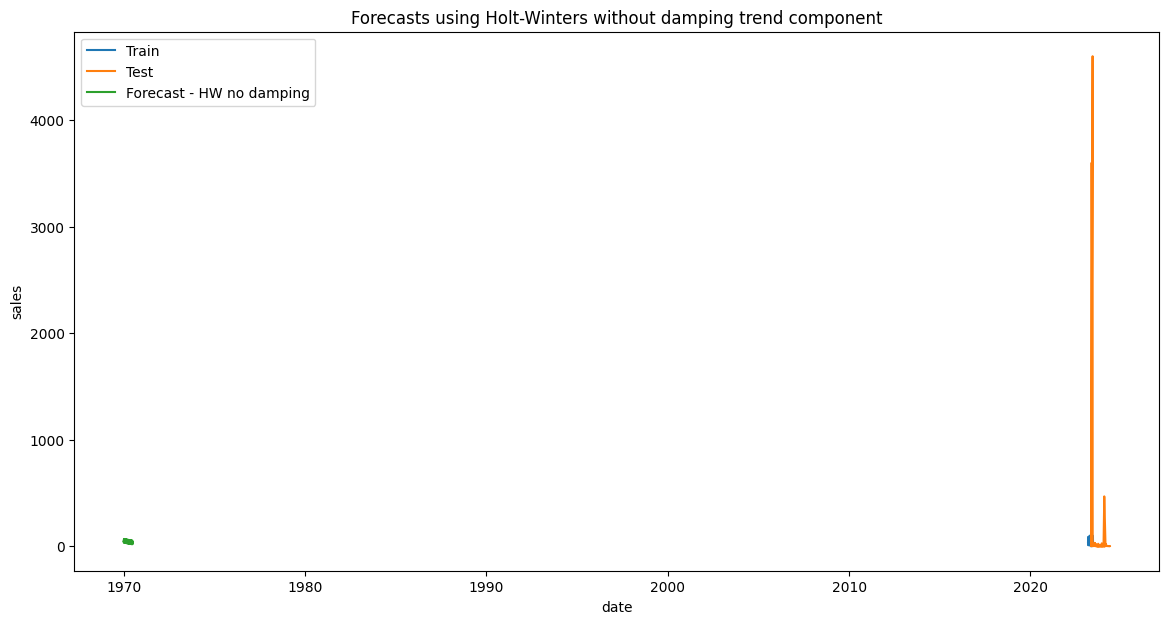

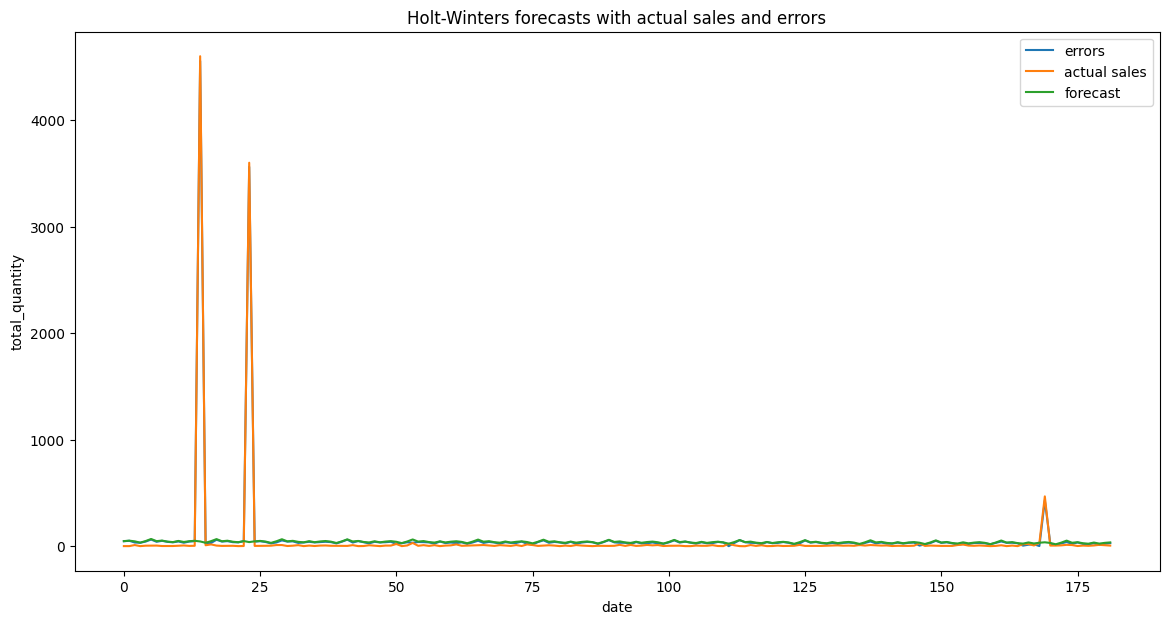

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters,9799,7210.209098,2588.790902,14.224126,431.29381,inf


In [42]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_df1 and test_df1 are your training and test DataFrames
# Fit an ExponentialSmoothing model to the training data
model = ExponentialSmoothing(train_df1['total_quantity'], trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit()

# Generate predictions for the test period
pred_sales = fit.forecast(len(test_df1))

# Merge predictions and actual sales into one DataFrame
pred_fit_1 = pd.DataFrame({'date': test_df1.index, 'pred_sales': pred_sales})
errors_df_hw = pd.merge(test_df1, pred_fit_1, left_index=True, right_on='date')
errors_df_hw['errors'] = errors_df_hw['total_quantity'] - errors_df_hw['pred_sales']
errors_df_hw.insert(0, 'model', 'Holt-Winters')

# Plot the forecasts
plt.figure(figsize=(14,7))
plt.plot(train_df1['date'], train_df1['total_quantity'], label='Train')
plt.plot(test_df1['date'], test_df1['total_quantity'], label='Test')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='Forecast - HW no damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters without damping trend component')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(errors_df_hw['date'], np.abs(errors_df_hw['errors']), label='errors')
plt.plot(errors_df_hw['date'], errors_df_hw['total_quantity'], label='actual sales')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('total_quantity')
plt.title('Holt-Winters forecasts with actual sales and errors')
plt.show()

# Define a function to calculate Mean Absolute Percentage Error (MAPE)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Aggregate results
result_df_hw = errors_df_hw.groupby('model').agg(total_sales=('total_quantity', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', 'mean'),
                                          RMSE=('errors', lambda x: np.sqrt(np.mean(x**2))),
                                          MAPE=('total_quantity', lambda x: mape(x, errors_df_hw['pred_sales'])))

result_df_hw


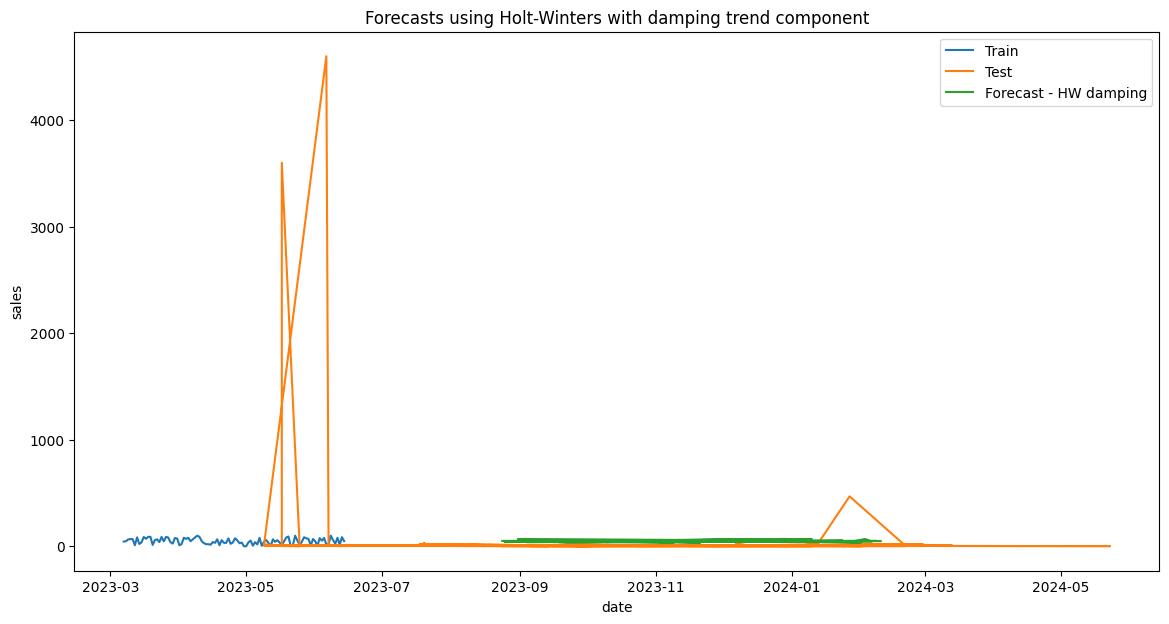

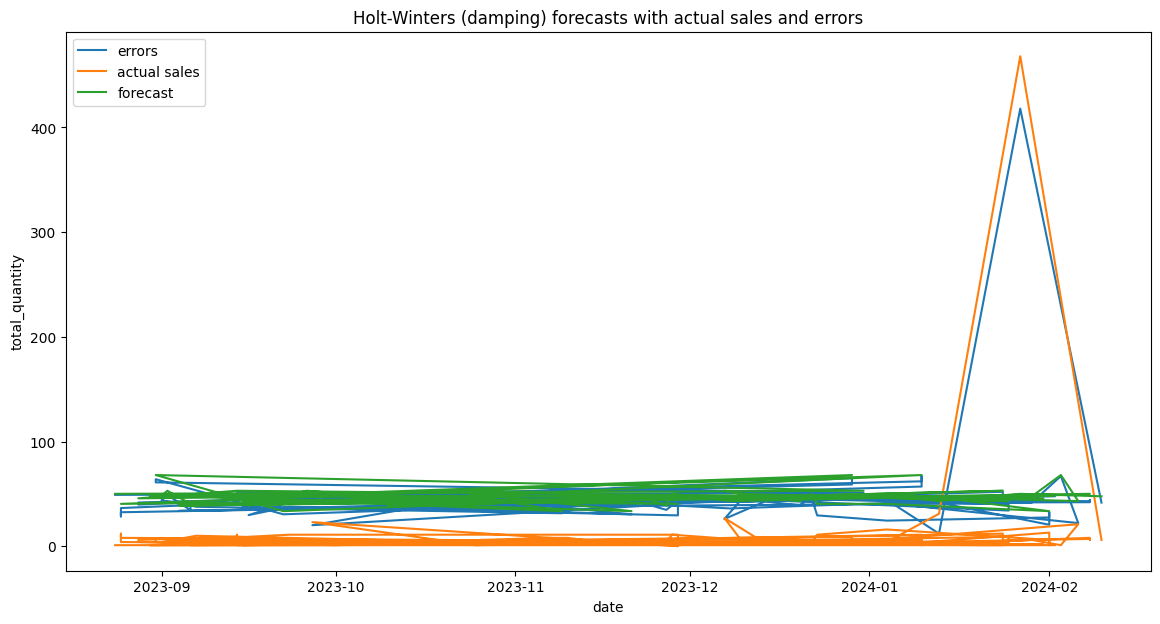

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters-Damped,1028,4598.529107,-3570.529107,45.427357,60.03625,inf


In [48]:
# Merge predictions and actual sales into one df
errors_df_hwd = pd.merge(test_df1, pred_fit_2, left_on='date', right_on='index')
errors_df_hwd = errors_df_hwd[['date', 'total_quantity','pred_sales']]
errors_df_hwd['errors'] = errors_df_hwd.total_quantity - errors_df_hwd.pred_sales
errors_df_hwd.insert(0, 'model', 'Holt-Winters-Damped')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df1['date'], train_df1['total_quantity'], label='Train')
plt.plot(test_df1['date'], test_df1['total_quantity'], label='Test')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='Forecast - HW damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters with damping trend component')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(errors_df_hwd['date'], np.abs(errors_df_hwd['errors']), label='errors')
plt.plot(errors_df_hwd['date'], errors_df_hwd['total_quantity'], label='actual sales')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('total_quantity')
plt.title('Holt-Winters (damping) forecasts with actual sales and errors')
plt.show()

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


result_df_hwd = errors_df_hwd.groupby('model').agg(
    total_sales=('total_quantity', 'sum'),
    total_pred_sales=('pred_sales', 'sum'),
    holt_winters_overall_error=('errors', 'sum'),
    MAE=('errors', mae),
    RMSE=('errors', rmse),
    MAPE=('total_quantity', lambda x: mape(x, errors_df_hwd['pred_sales']))
)

result_df_hwd

### 3. Autoregressive Integrated Moving Average - ARIMA Model

#### Step 1: Check stationarity

Before going any further into our analysis, our series has to be made stationary.

Stationarity is the property of exhibiting constant statistical properties (mean, variance, autocorrelation, etc.). If the mean of a time-series increases over time, then it’s not stationary.

The mean across many time periods is only informative if the expected value is the same across those time periods. If these population parameters can vary, what are we really estimating by taking an average across time?

Stationarity requires that the statistical properties must be the same across time, making the sample average a reasonable way to estimate them.

<b> Methods to Check Stationarity </b>

1. <b>Plotting rolling statistics:</b> Plotting rolling means and variances is a first good way to visually inspect our series. If the rolling statistics exhibit a clear trend (upwards or downwards) and show varying variance (increasing or decreasing amplitude), then you might conclude that the series is very likely not to be stationary.



2. <b>Augmented Dickey-Fuller Test:</b> This test is used to assess whether or not a time-series is stationary. It gives a result called a “test-statistic”, based on which you can say, with different levels (or percentage) of confidence, if the time-series is stationary or not. The <b>test statistic</b> is expected to be negative; therefore, it has to be more <b>negative(less)</b> than the <b>critical value</b> for the <b>hypothesis to be rejected</b> and conclude that <b>series is stationary</b>.



3. <b> ACF and PACF plots: </b> An autocorrelation (ACF) plot represents the autocorrelation of the series with lags of itself. A partial autocorrelation (PACF) plot represents the amount of correlation between a series and a lag of itself that is not explained by correlations at all lower-order lags.
Ideally, we want no correlation between the series and lags of itself. Graphically speaking, we would like all the spikes to fall in the blue region.

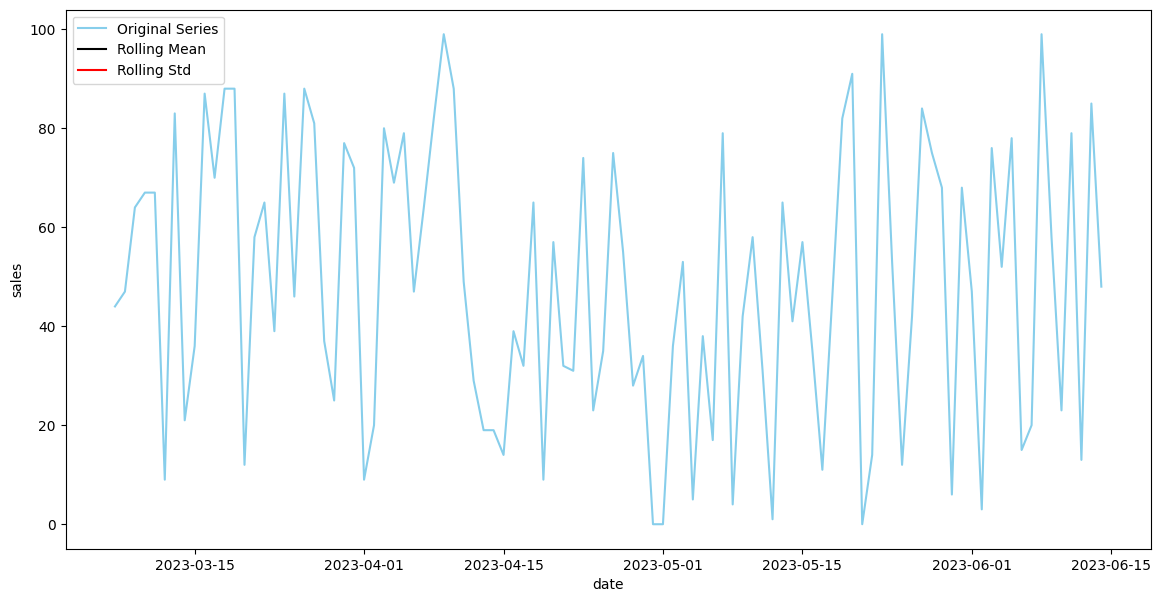

Test statistic = -9.701
P-value = 0.000
Critical values :
	1%: -3.498198082189098 - The data is  stationary with 99% confidence
	5%: -2.891208211860468 - The data is  stationary with 95% confidence
	10%: -2.5825959973472097 - The data is  stationary with 90% confidence


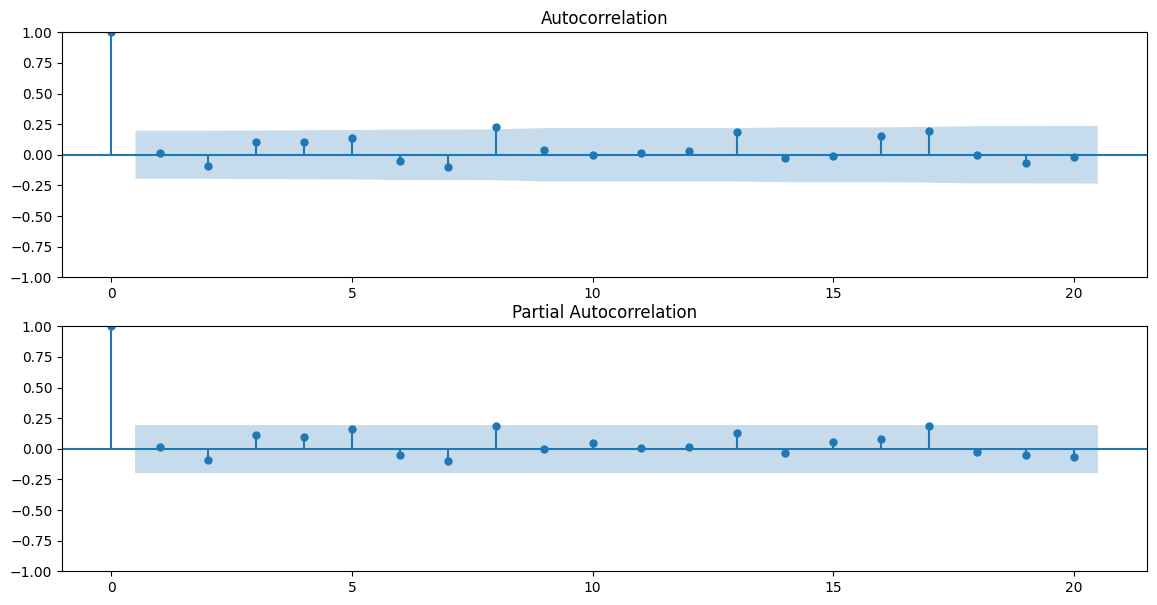

In [49]:
arima_df = train_df1[['date', 'total_quantity']].set_index('date')
arima_test_df = test_df1[['date', 'total_quantity']].set_index('date')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()

    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")

    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))

    # Autocorrelation Plots
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)

test_stationarity(arima_df.total_quantity)

Looking at the results from our test, we can conclude that the series is not stationary. Therefore, in order to make the series stationary we apply <b> Differencing </b>

#### Step 2: Differencing

<b>Differencing:</b> Seasonal or cyclical patterns can be removed by substracting periodical values. If the data is 12-month seasonal, substracting the series with a 12-lag difference series will give a “flatter” series. Since we have aggregated the data to each day-level, we will shift by 1.

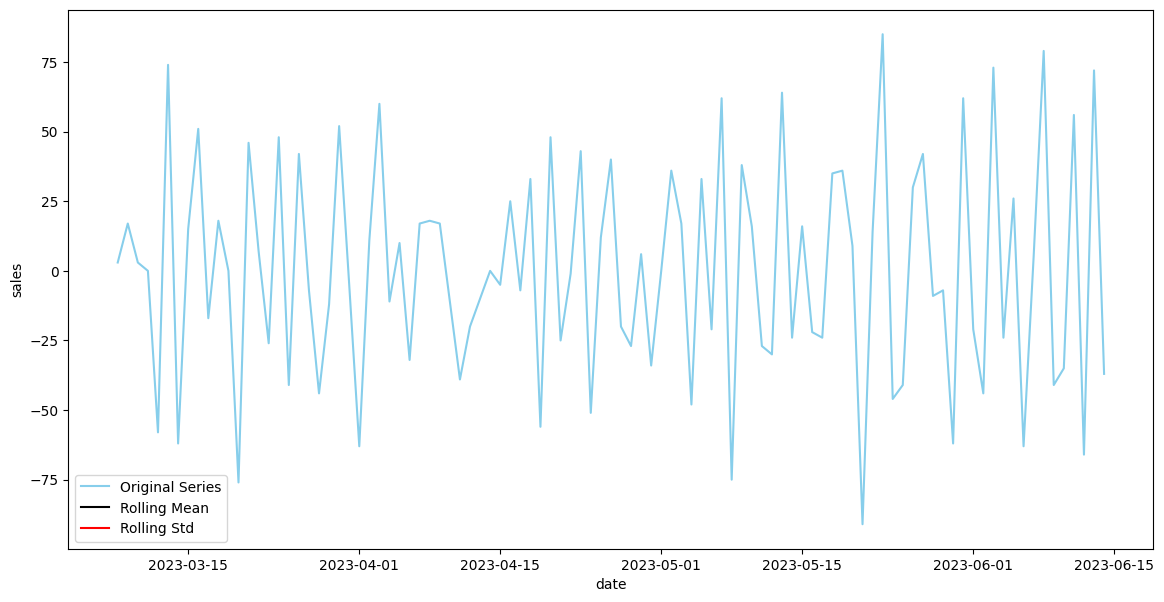

Test statistic = -6.508
P-value = 0.000
Critical values :
	1%: -3.503514579651927 - The data is  stationary with 99% confidence
	5%: -2.893507960466837 - The data is  stationary with 95% confidence
	10%: -2.583823615311909 - The data is  stationary with 90% confidence


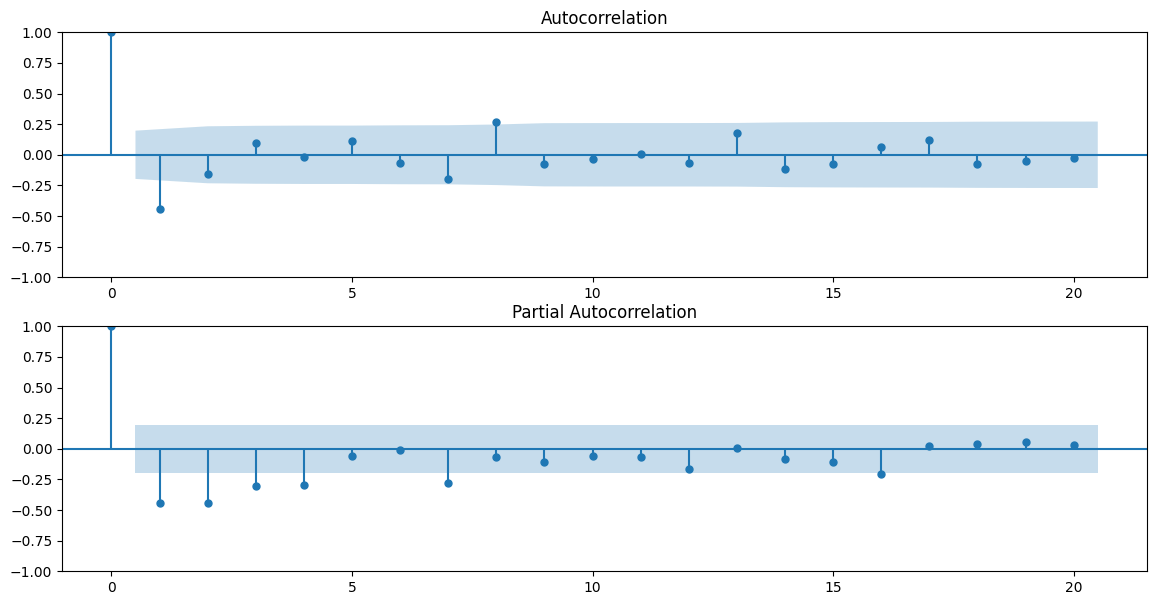

In [52]:
first_difference = arima_df.total_quantity - arima_df.total_quantity.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
# Check for stationarity after differencing
test_stationarity(first_difference.total_quantity)

After applying Differencing to the series, we can see from the above results that the series is now stationary, i.e. mean and variance are constant over time, and from ADF we can verify that the test-statistic is lesser than the critical value, hence we can reject the null hypothesis and conclude that the series is staionary.

#### Step 3: Model Building
#### Interpreting the AR(p), I(d), MA(q) values:

1. <b>Determining I(d):</b>

    Taking the first order difference makes the time series stationary. Therefore, <b>I(d) = 1.</b>
    

2. <b>Determining AR(p):</b> If the lag-1 autocorrelation of the differenced series PACF is negative, and/or there is a sharp cutoff, then choose a AR order of 1.

    From the PACF plot we can clearly observe that within 6 lags the AR is significant. Therefore, we can use <b>AR(p) = 6</b>,  (6 lines are crossed the blue lines so 6past days are required to predict).


3. <b>Determining MA(q):</b> If the lag-1 autocorrelation of the differenced series ACF is negative, and/or there is a sharp cutoff, then choose a MA order of 1.

    From tha ACF plot we see a negative spike at lag 1, therfore we can use <b> MA(q) = 1</b>

In [53]:
from statsmodels.tsa.arima.model import ARIMA

arima_model61 = ARIMA(arima_df.total_quantity, order=(6, 1, 1)).fit()
print(arima_model61.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         total_quantity   No. Observations:                  100
Model:                 ARIMA(6, 1, 1)   Log Likelihood                -470.232
Date:                Tue, 19 Mar 2024   AIC                            956.463
Time:                        04:03:25   BIC                            977.224
Sample:                    03-07-2023   HQIC                           964.863
                         - 06-14-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0554      0.124     -0.446      0.656      -0.299       0.188
ar.L2         -0.1764      0.138     -1.275      0.202      -0.448       0.095
ar.L3          0.0584      0.140      0.416      0.6

### Plotting the residuals using ACF and PACF

Plotting the residuals shows that recurring correlation exists in both ACF and PACF. So we need to deal with seasonality. When the plots of ACF and PACF are similar or any sesaonality is present between them then, we need to apply the Seasonal ARIMA (SARIMA) model.

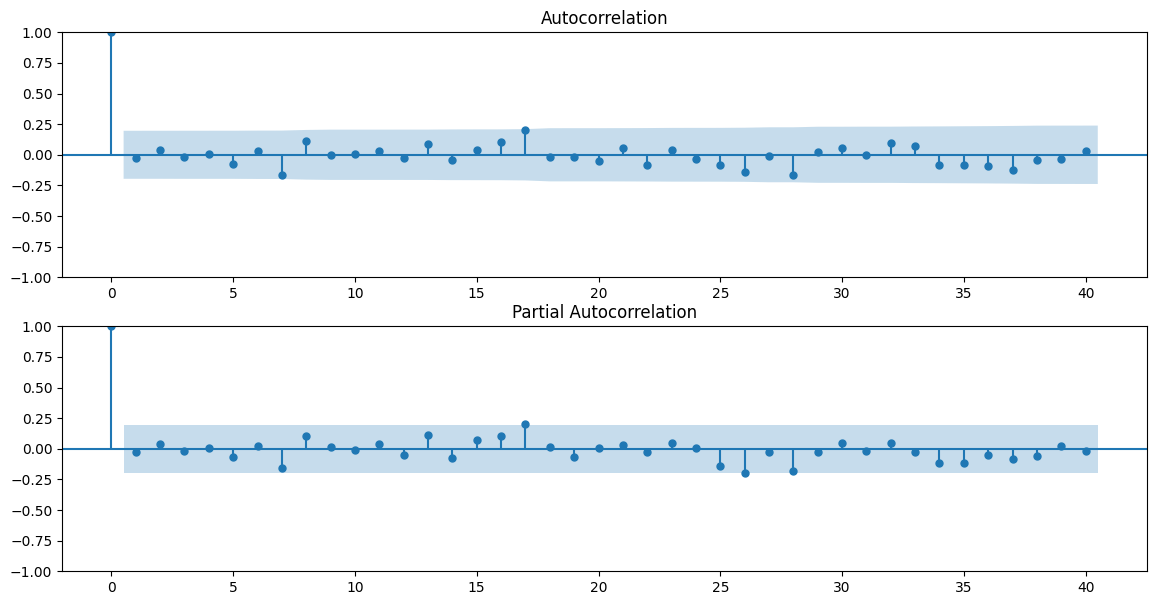

In [54]:
residuals = arima_model61.resid
# Checking for seasonality
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0] = plot_acf(residuals, ax=ax[0], lags=40)
ax[1] = plot_pacf(residuals, ax=ax[1], lags=40)

In [61]:
# fit the model with reduced lags
sarima_model = SARIMAX(arima_df.total_quantity, order=(6, 1, 0), seasonal_order=(6, 1, 0, 7),
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit(start_params=None, maxiter=100, method='powell', full_output=1, disp=5,
                               callback=None, return_params=False, optim_score=None, optim_complex_step=None,
                               optim_hessian=None, flags=None, low_memory=False)
arima_test_df['pred_sales'] = sarima_fit.predict(start=arima_test_df.index[0],
                                                 end=arima_test_df.index[-1], dynamic= True)
plot = sarima_fit.plot_diagnostics(lags=min(10, len(arima_df.total_quantity)), figsize=(14,7))
plot


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 2.053681
         Iterations: 13
         Function evaluations: 1440


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1400x700 with 0 Axes>

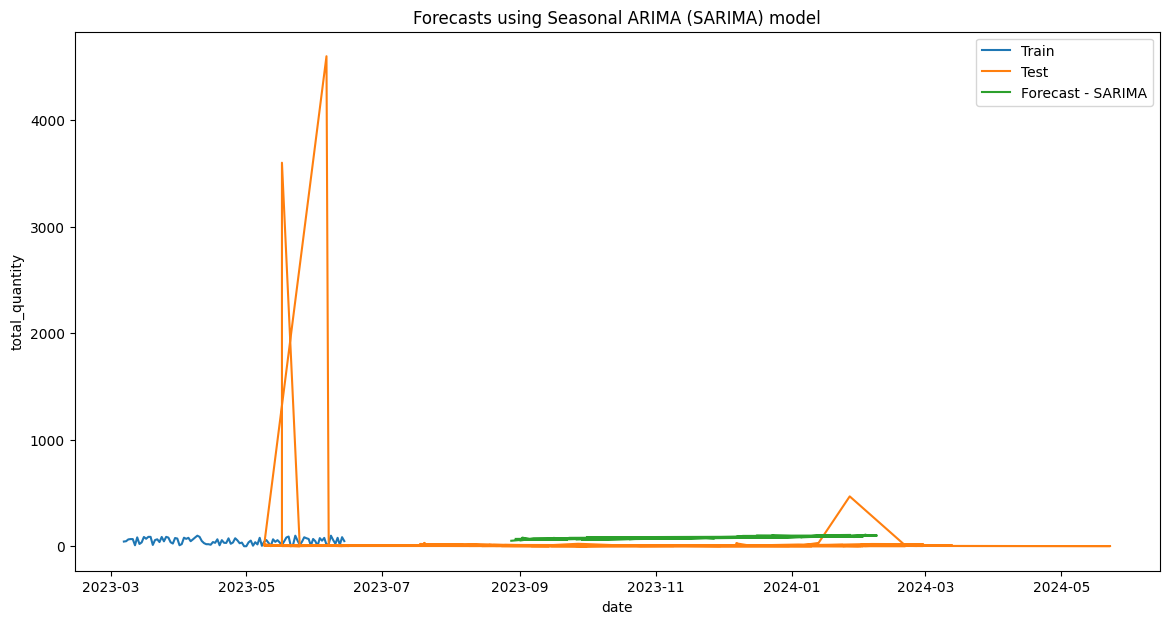

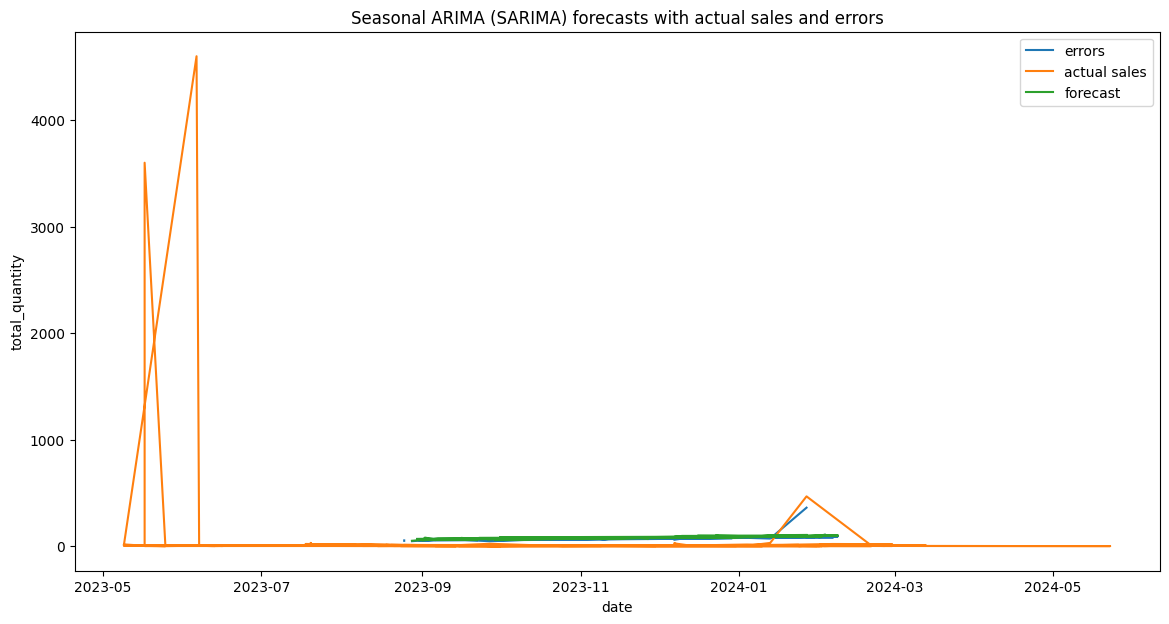

,total_sales,total_pred_sales,SARIMA_overall_error,MAE,RMSE,MAPE
model,,,,,,
SARIMA,9799,7858.830667,-6830.830667,-70.420935,84.336477,inf


In [64]:
# Calculate errors
arima_test_df['errors'] = arima_test_df['total_quantity'] - arima_test_df['pred_sales']

# Replace existing 'model' column with 'SARIMA'
arima_test_df['model'] = 'SARIMA'

# Evaluate the predictions for Seasonal ARIMA model
plt.figure(figsize=(14,7))
plt.plot(train_df1['date'], train_df1['total_quantity'], label='Train')
plt.plot(arima_test_df.index, arima_test_df['total_quantity'], label='Test')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('total_quantity')
plt.title('Forecasts using Seasonal ARIMA (SARIMA) model')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(arima_test_df.index, np.abs(arima_test_df['errors']), label='errors')
plt.plot(arima_test_df.index, arima_test_df['total_quantity'], label='actual sales')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('total_quantity')
plt.title('Seasonal ARIMA (SARIMA) forecasts with actual sales and errors')
plt.show()

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

result_df_sarima = arima_test_df.groupby('model').agg(
    total_sales=('total_quantity', 'sum'),
    total_pred_sales=('pred_sales', 'sum'),
    SARIMA_overall_error=('errors', 'sum'),
    MAE=('errors', 'mean'),
    RMSE=('errors', rmse),
    MAPE=('total_quantity', lambda x: mape(x, arima_test_df['pred_sales']))
)
result_df_sarima



### 4. Supervised Machine Learning: Linear Regression

Let's apply Linear Regression to our time series data in order to forecasts sales.

In [65]:
reg_df = df
reg_df

,date,total_quantity,year,month,day,weekday
0,2016-10-12,1,2016.0,10.0,12.0,2.0
1,2016-09-12,1,2016.0,9.0,12.0,7.0
2,2016-09-13,1,2016.0,9.0,13.0,1.0
3,2016-09-23,4,2016.0,9.0,23.0,4.0
4,2016-09-23,5,2016.0,9.0,23.0,4.0
...,...,...,...,...,...,...
988,2024-02-16,4,2024.0,2.0,16.0,4.0
989,2024-02-15,7,2024.0,2.0,15.0,3.0
990,2024-02-15,13,2024.0,2.0,15.0,3.0
991,2024-02-16,9,2024.0,2.0,16.0,4.0


#### Step 1: Feature Engineering

In [80]:
# Lag features
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_df[lag_i] = reg_df.total_quantity.shift(i)

# Rolling window
reg_df['rolling_mean'] = reg_df.total_quantity.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.total_quantity.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.total_quantity.rolling(window=7).min()

reg_df = reg_df.dropna(how='any', inplace=False)
# reg_df = reg_df.drop(['store', 'item'], axis=1)

# Split the series to predict the last 3 months of 2017
reg_df.reset_index(inplace=True)
reg_df = reg_df.set_index('date')
reg_train_df = reg_df.loc[:'20-06-2022']
reg_test_df = reg_df.loc['25-03-2023':]

#### Step 2: Feature Selection and Model Building

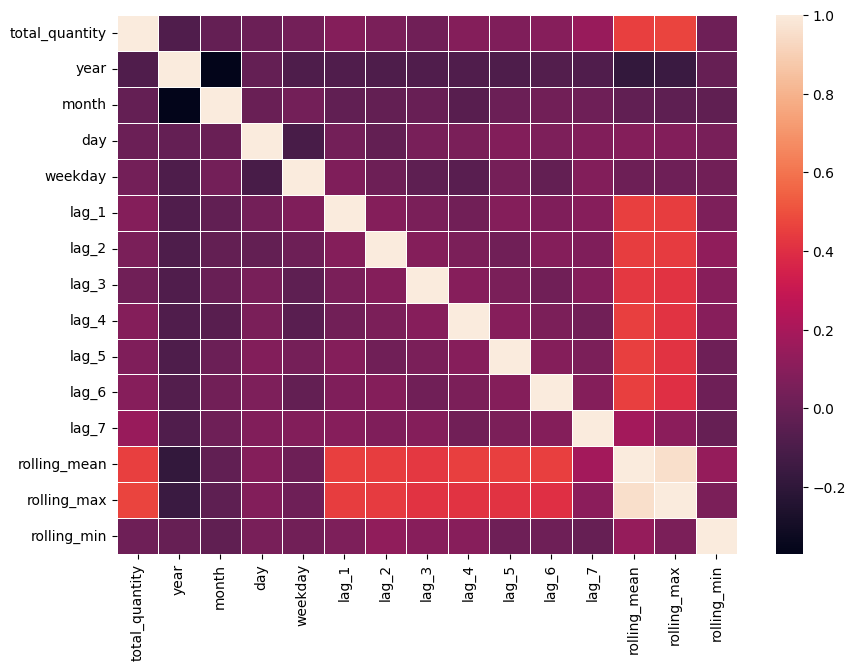

In [81]:
# Correlation matrix with heatmap
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
_ = sn.heatmap(corr, linewidths=.5)

In [82]:
X_train = reg_train_df.drop(['total_quantity'], axis=1)
y_train = reg_train_df['total_quantity'].values

X_test = reg_test_df.drop(['total_quantity'], axis=1)
y_test = reg_test_df['total_quantity'].values

#Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns
print(feature_scores.nlargest(5,'Score'))  # print 5 best features

         Feature       Score
12   rolling_max  150.575192
11  rolling_mean  140.555938
10         lag_7   12.787339
9          lag_6    4.730962
4          lag_1    4.337637


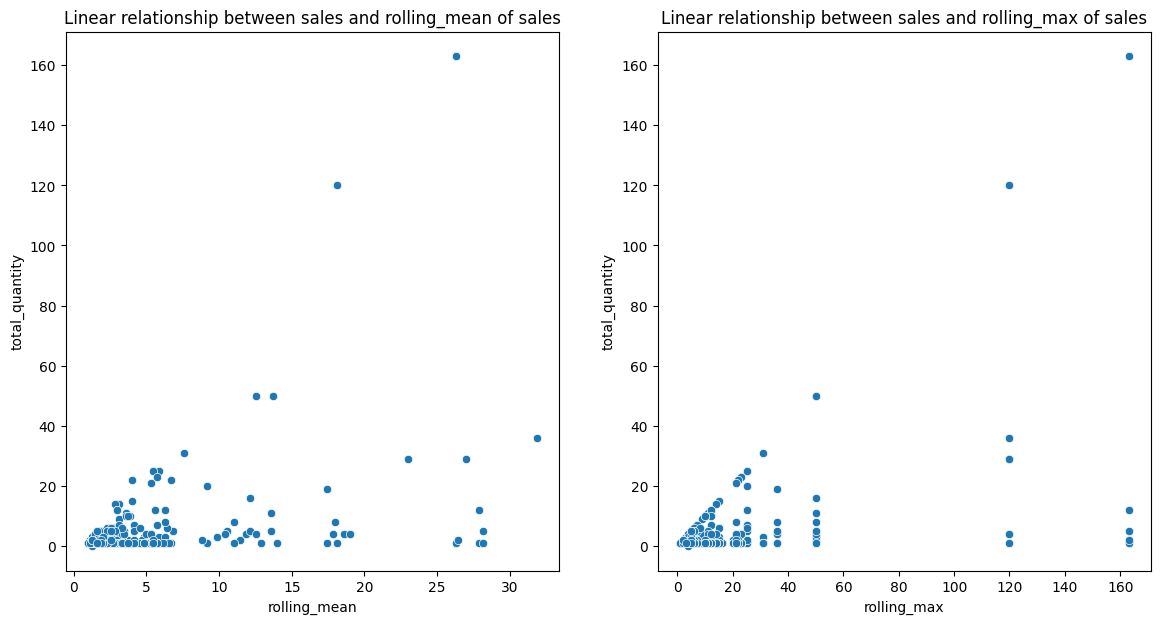

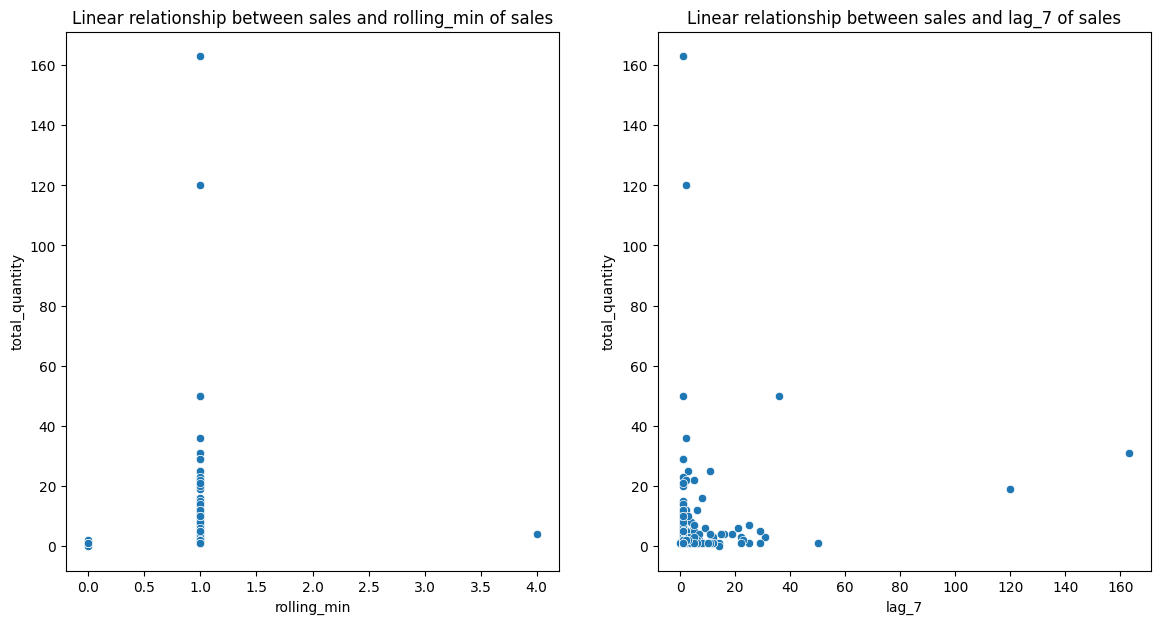

In [83]:
import seaborn as sn

# Checking for a linear relationship of the top features with sales (target variable)
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(x=reg_train_df.rolling_mean, y=reg_train_df.total_quantity, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sn.scatterplot(x=reg_train_df.rolling_max, y=reg_train_df.total_quantity, ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(x=reg_train_df.rolling_min, y=reg_train_df.total_quantity, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sn.scatterplot(x=reg_train_df.lag_7, y=reg_train_df.total_quantity, ax=axs[1])
_ = axs[1].set(title='Linear relationship between sales and lag_7 of sales')


In [84]:
# update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

errors_df = reg_test_df[['total_quantity']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

#### Step 3: Model Evaluation and Predictions

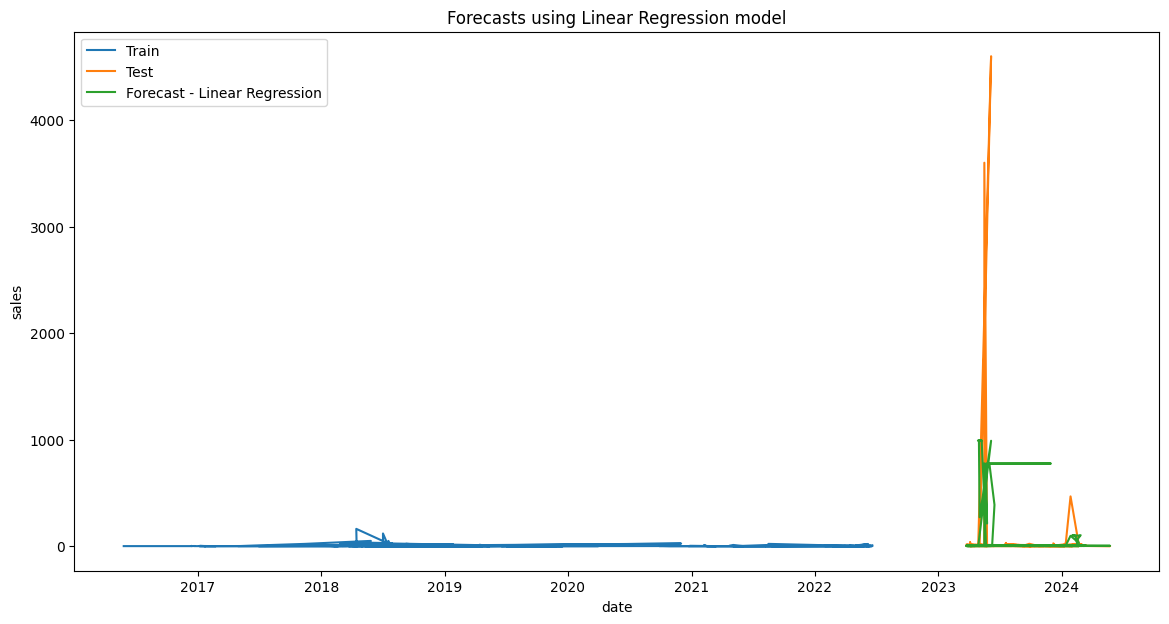

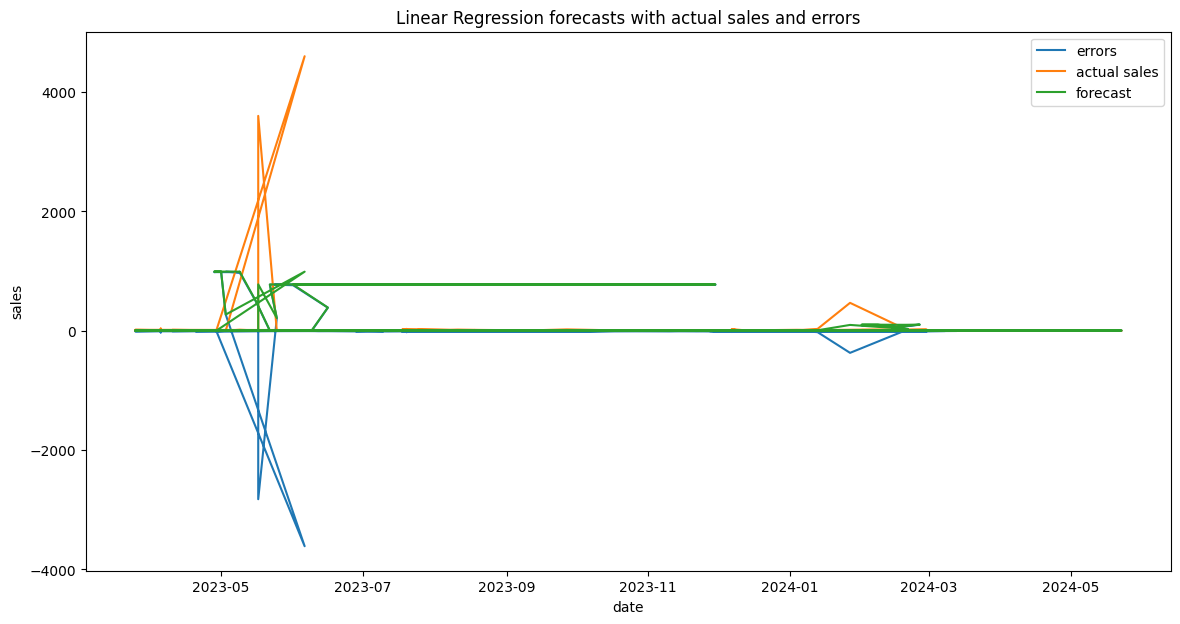

,total_sales,total_pred_sales,LR_overall_error,MAE,RMSE,MAPE
model,,,,,,
LinearRegression,10016,13409.491349,3393.491349,15.355164,365.38976,inf


In [85]:
# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['total_quantity'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['total_quantity'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.total_quantity, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

result_df_lr = errors_df.groupby('model').agg(
    total_sales=('total_quantity', 'sum'),
    total_pred_sales=('pred_sales', 'sum'),
    LR_overall_error=('errors', 'sum'),
    MAE=('errors', 'mean'),
    RMSE=('errors', rmse),
    MAPE=('total_quantity', lambda x: mape(x, errors_df['pred_sales']))
)
result_df_lr


Train MAE: 93.25791592981092, Test MAE: 55.05885044939564
Train RMSE: 439.715262790933, Test RMSE: 77.88968168993094


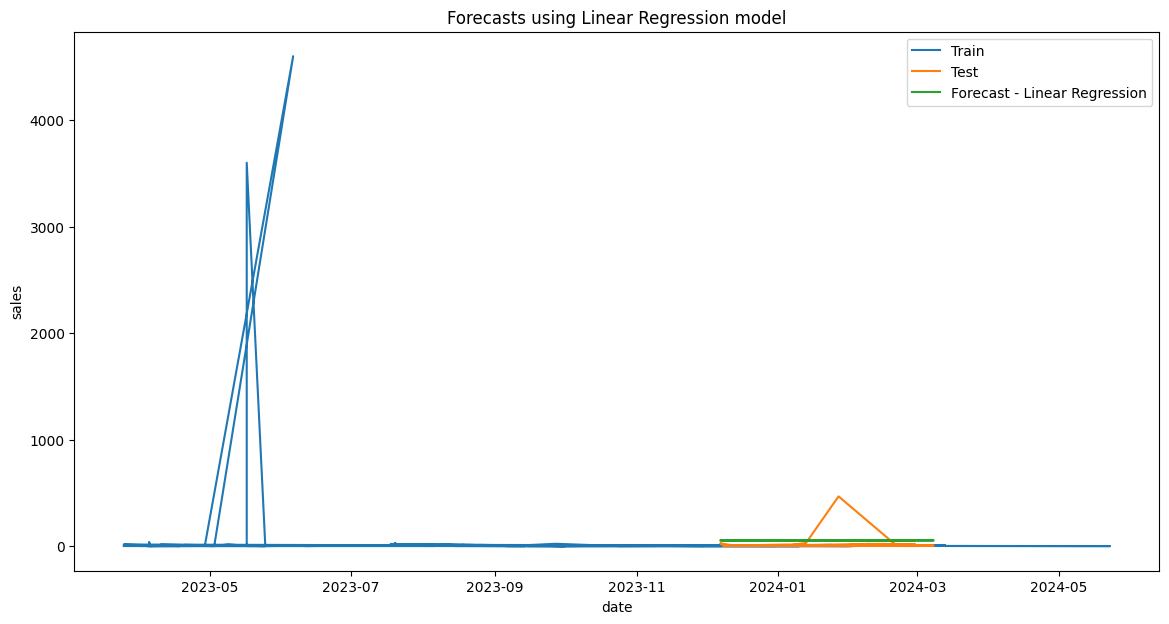

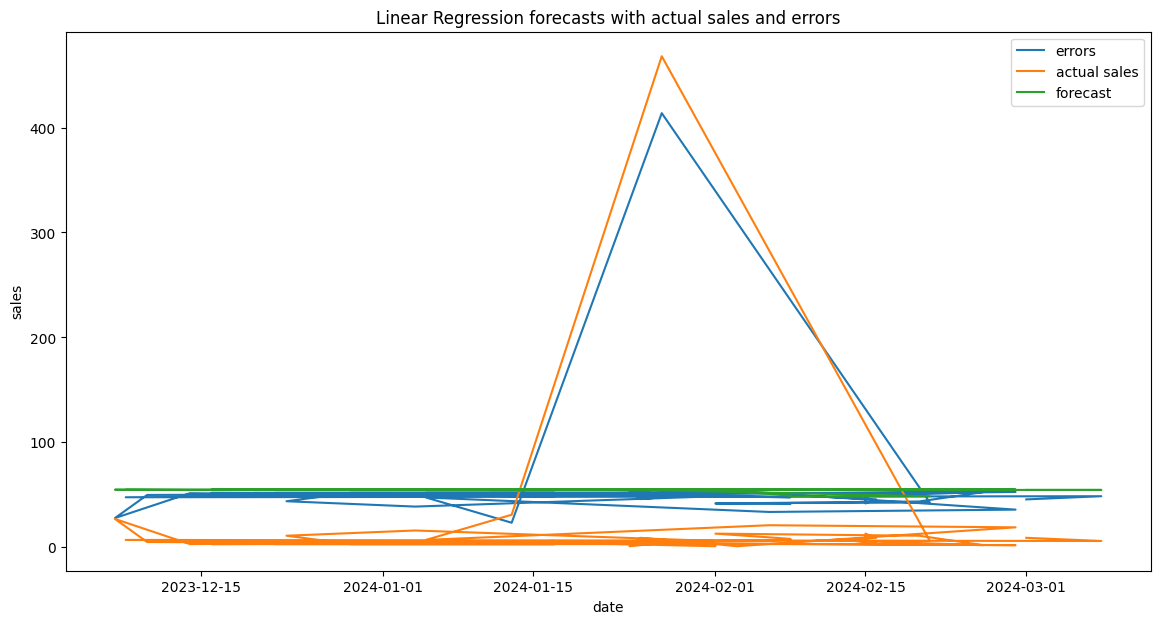

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming errors_df is your DataFrame with 'total_quantity', 'pred_sales', and 'model' columns

# Feature Engineering: Adding lag features
errors_df['lag_1'] = errors_df['total_quantity'].shift(1)
errors_df['lag_2'] = errors_df['total_quantity'].shift(2)
errors_df['lag_3'] = errors_df['total_quantity'].shift(3)

# Dropping NaN values
errors_df.dropna(inplace=True)

# Check if there are enough samples for training
if len(errors_df) < 4:
    print("Not enough data for training after adding lag features. Please check your data.")
else:
    # Splitting the data into train and test sets
    train_size = int(0.8 * len(errors_df))
    train_df = errors_df[:train_size]
    test_df = errors_df[train_size:]

    # Defining the features and target variable
    X_train = train_df[['lag_1', 'lag_2', 'lag_3']]
    y_train = train_df['total_quantity']
    X_test = test_df[['lag_1', 'lag_2', 'lag_3']]
    y_test = test_df['total_quantity']

    # Check if there are enough samples for training after splitting
    if len(X_train) < 1 or len(X_test) < 1:
        print("Not enough data for training after splitting. Please check your data.")
    else:
        # Initialize and fit the linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Make predictions
        train_df['pred_sales'] = model.predict(X_train)
        test_df['pred_sales'] = model.predict(X_test)

        # Evaluate the model
        mae_train = mean_absolute_error(y_train, train_df['pred_sales'])
        mae_test = mean_absolute_error(y_test, test_df['pred_sales'])
        rmse_train = mean_squared_error(y_train, train_df['pred_sales'], squared=False)
        rmse_test = mean_squared_error(y_test, test_df['pred_sales'], squared=False)

        print(f"Train MAE: {mae_train}, Test MAE: {mae_test}")
        print(f"Train RMSE: {rmse_train}, Test RMSE: {rmse_test}")

        # Plot the actual vs predicted sales
        plt.figure(figsize=(14, 7))
        plt.plot(train_df.index, train_df['total_quantity'], label='Train')
        plt.plot(test_df.index, test_df['total_quantity'], label='Test')
        plt.plot(test_df.index, test_df['pred_sales'], label='Forecast - Linear Regression')
        plt.legend(loc='best')
        plt.xlabel('date')
        plt.ylabel('sales')
        plt.title('Forecasts using Linear Regression model')
        plt.show()

        # Plot the errors, actual sales, and forecast
        plt.figure(figsize=(14, 7))
        plt.plot(test_df.index, np.abs(test_df['total_quantity'] - test_df['pred_sales']), label='errors')
        plt.plot(test_df.index, test_df['total_quantity'], label='actual sales')
        plt.plot(test_df.index, test_df['pred_sales'], label='forecast')
        plt.legend(loc='best')
        plt.xlabel('date')
        plt.ylabel('sales')
        plt.title('Linear Regression forecasts with actual sales and errors')
        plt.show()
